Importy

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

Wczytywanie danych

In [51]:
print("="*80)
print("WCZYTYWANIE DANYCH")
print("="*80)

# Główne datasety - KODY JAKO STRING!
df_complete = pd.read_csv('./output/complete_dataset.csv', dtype={'powiat_code': str})
df_ml_ready = pd.read_csv('./output/ml_ready_dataset.csv', dtype={'powiat_code': str})
df_2024 = pd.read_csv('./output/complete_dataset_2024.csv', dtype={'powiat_code': str})

# Szczegółowe datasety - KODY JAKO STRING!
df_crime_counts = pd.read_csv('./output/crime/crime_counts_powiaty.csv', dtype={'region_code': str})
df_crime_detection = pd.read_csv('./output/crime/crime_detection_rates_powiaty.csv', dtype={'region_code': str})
df_population = pd.read_csv('./output/population/population_with_density.csv', dtype={'powiat_code': str})
df_unemployment = pd.read_csv('./output/socio/unemployment_powiaty.csv', dtype={'powiat_code': str})
df_wages = pd.read_csv('./output/socio/wages_powiaty.csv', dtype={'powiat_code': str})

print(f"\n✓ Wczytano complete_dataset: {df_complete.shape}")
print(f"✓ Wczytano ml_ready_dataset: {df_ml_ready.shape}")
print(f"✓ Wczytano complete_dataset_2024: {df_2024.shape}")
print(f"✓ Wczytano crime_counts: {df_crime_counts.shape}")
print(f"✓ Wczytano crime_detection: {df_crime_detection.shape}")

WCZYTYWANIE DANYCH

✓ Wczytano complete_dataset: (4752, 29)
✓ Wczytano ml_ready_dataset: (3179, 29)
✓ Wczytano complete_dataset_2024: (396, 29)
✓ Wczytano crime_counts: (28512, 5)
✓ Wczytano crime_detection: (28512, 5)


Statystyki

In [52]:
print("\n" + "="*80)
print("PODSTAWOWE STATYSTYKI - COMPLETE DATASET")
print("="*80)

print("\n--- Informacje o datasecie ---")
print(f"Okres danych: {df_complete['year'].min()} - {df_complete['year'].max()}")
print(f"Liczba powiatów: {df_complete['powiat_code'].nunique()}")
print(f"Liczba lat: {df_complete['year'].nunique()}")
print(f"Całkowita liczba rekordów: {len(df_complete)}")
print(f"Braki danych: {df_complete.isnull().sum().sum()} ({df_complete.isnull().sum().sum() / df_complete.size * 100:.2f}%)")

print("\n--- Statystyki crime_rate_per_100k ---")
print(df_complete['crime_rate_per_100k'].describe())

print("\n--- Top 5 kolumn z brakami danych ---")
missing_cols = df_complete.isnull().sum().sort_values(ascending=False).head()
print(missing_cols[missing_cols > 0])

print("\n--- Rozkład danych po latach ---")
print(df_complete['year'].value_counts().sort_index())


PODSTAWOWE STATYSTYKI - COMPLETE DATASET

--- Informacje o datasecie ---
Okres danych: 2013 - 2024
Liczba powiatów: 396
Liczba lat: 12
Całkowita liczba rekordów: 4752
Braki danych: 11074 (8.04%)

--- Statystyki crime_rate_per_100k ---
count     4560.000000
mean      1877.788436
std       1320.682159
min        478.300000
25%       1259.667500
50%       1629.825000
75%       2155.682500
max      35859.630000
Name: crime_rate_per_100k, dtype: float64

--- Top 5 kolumn z brakami danych ---
wage_category            1142
wage_index               1140
unemployment_rate        1140
unemployment_category    1140
social_risk_score        1140
dtype: int64

--- Rozkład danych po latach ---
year
2013    396
2014    396
2015    396
2016    396
2017    396
2018    396
2019    396
2020    396
2021    396
2022    396
2023    396
2024    396
Name: count, dtype: int64


In [53]:
print("\n" + "="*80)
print("STATYSTYKI ML_READY DATASET (bez braków)")
print("="*80)

print(f"\nLiczba rekordów: {len(df_ml_ready)}")
print(f"Usunięto rekordów z brakami: {len(df_complete) - len(df_ml_ready)}")

print("\n--- Statystyki kluczowych features ---")
key_features = ['crime_rate_per_100k', 'population_density', 'unemployment_rate', 
                'wage_index', 'youth_ratio', 'gender_ratio']
print(df_ml_ready[key_features].describe())


STATYSTYKI ML_READY DATASET (bez braków)

Liczba rekordów: 3179
Usunięto rekordów z brakami: 1573

--- Statystyki kluczowych features ---
       crime_rate_per_100k  population_density  unemployment_rate  \
count          3179.000000         3179.000000        3179.000000   
mean           1816.792350          381.197763           8.671972   
std            1442.300054          666.081555           5.033246   
min             478.300000           17.930000           1.000000   
25%            1201.445000           59.790000           5.000000   
50%            1554.390000           97.290000           7.500000   
75%            2050.020000          212.580000          11.300000   
max           35859.630000         3961.080000          34.400000   

        wage_index  youth_ratio  gender_ratio  
count  3179.000000  3179.000000   3179.000000  
mean     86.139509     0.173687     95.578795  
std      10.900648     0.022549      3.455629  
min       0.000000     0.115200     83.500000  

Trendy czasowe

In [54]:
print("\n" + "="*80)
print("TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE")
print("="*80)

df_powiaty = df_complete[df_complete['powiat_code'].astype(str).str.endswith('00000') == False]

# Agregacja danych rocznych dla całej Polski
yearly_stats = df_powiaty.groupby('year').agg({
    'crime_rate_per_100k': 'mean',
    'total_crimes': 'sum',
    'total_population': 'sum',
    'unemployment_rate': 'mean',
    'wage_index': 'mean'
}).reset_index()

print("\n--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---")
print(yearly_stats[['year', 'crime_rate_per_100k', 'total_crimes']])

# Obliczenie zmian rok do roku
yearly_stats['crime_change_pct'] = yearly_stats['crime_rate_per_100k'].pct_change() * 100
yearly_stats['unemployment_change_pct'] = yearly_stats['unemployment_rate'].pct_change() * 100

print("\n--- Procentowe zmiany rok do roku ---")
print(yearly_stats[['year', 'crime_change_pct', 'unemployment_change_pct']].dropna())


TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE

--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---
    year  crime_rate_per_100k  total_crimes
0   2013          2296.340342      968824.0
1   2014          1881.450026      808161.0
2   2015          1778.121237      756649.0
3   2016          1620.976316      688976.0
4   2017          1690.274447      713777.0
5   2018          1745.580605      732339.0
6   2019          1796.083079      769620.0
7   2020          1876.605842      742705.0
8   2021          1962.812868      819184.0
9   2022          2104.624474      858326.0
10  2023          1925.545579      790303.0
11  2024          1855.046421      755428.0

--- Procentowe zmiany rok do roku ---
    year  crime_change_pct  unemployment_change_pct
1   2014        -18.067458               -14.097809
2   2015         -5.491976               -13.070435
3   2016         -8.837694               -14.530334
4   2017          4.275086               -18.480354
5   2018          3.27202

Wykres trendy polski

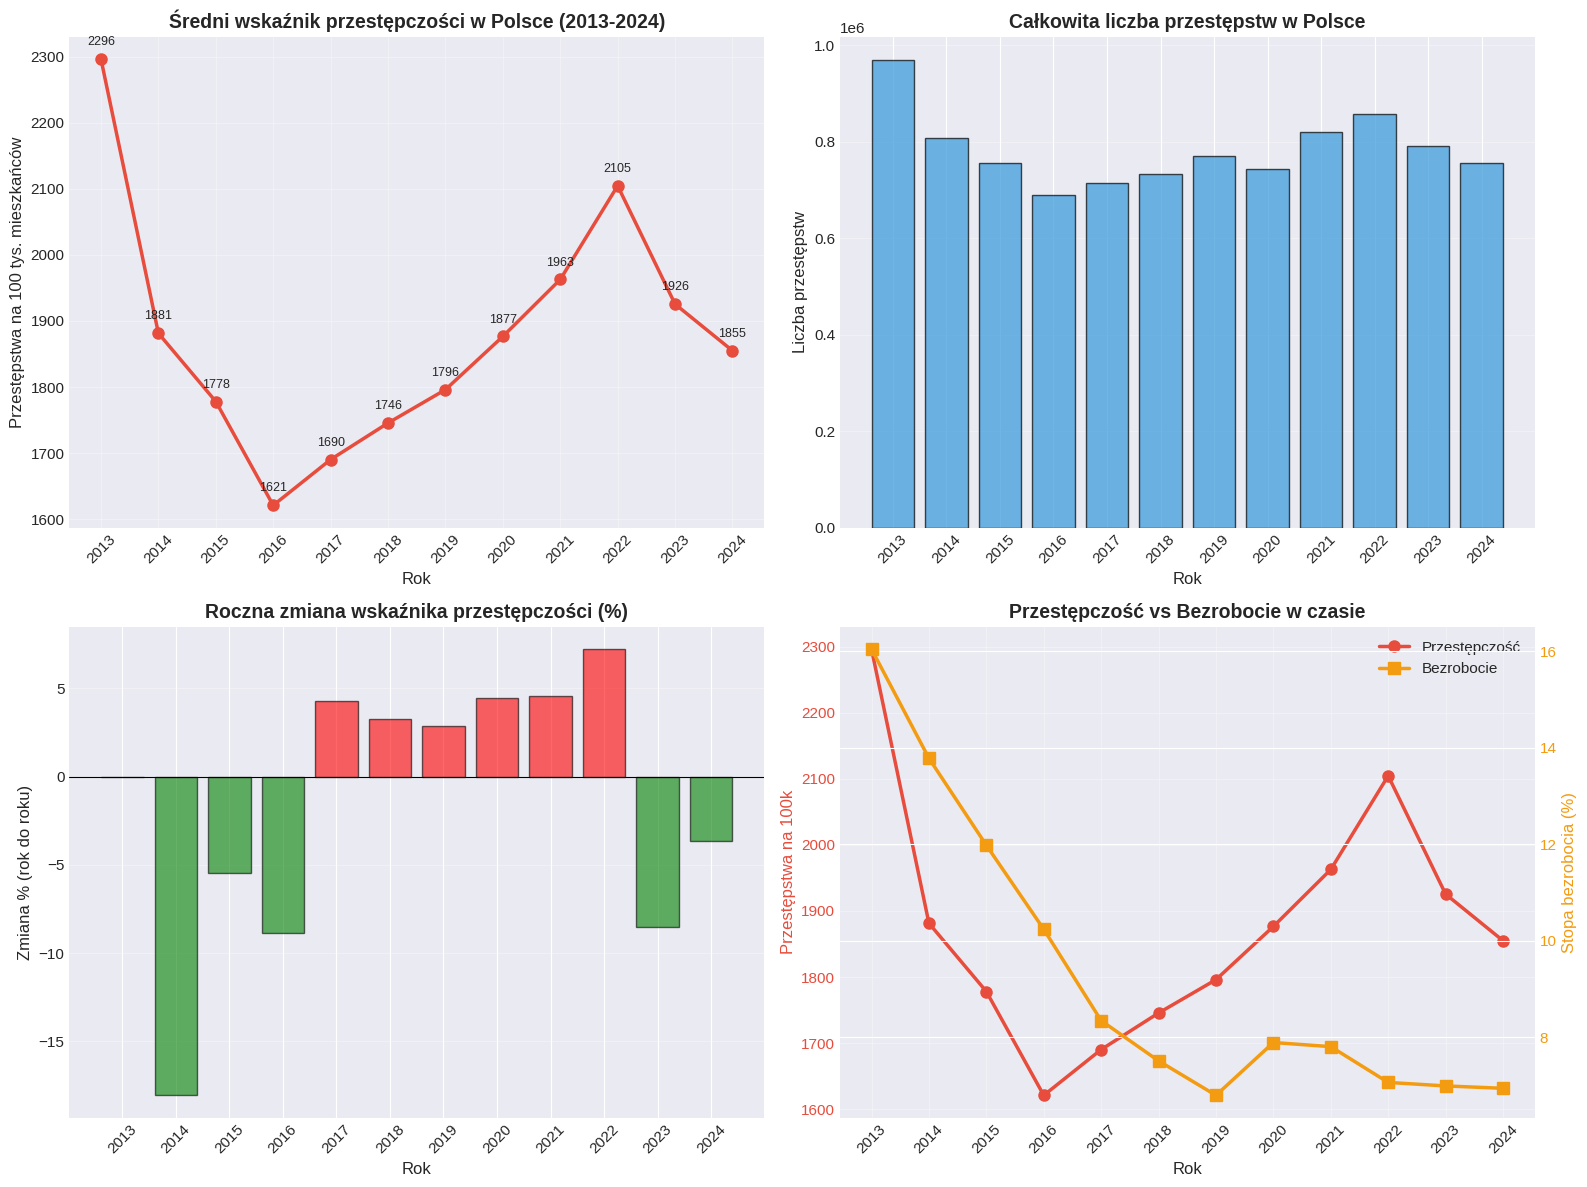


✓ Wykres zapisany jako 'trendy_czasowe_polska.png'


In [55]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Średni wskaźnik przestępczości w Polsce
ax1 = axes[0, 0]
ax1.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
         marker='o', linewidth=2.5, markersize=8, color='#e74c3c')
ax1.set_title('Średni wskaźnik przestępczości w Polsce (2013-2024)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(yearly_stats['year'])
ax1.set_xticklabels(yearly_stats['year'], rotation=45)

# Dodanie wartości na wykresie
for x, y in zip(yearly_stats['year'], yearly_stats['crime_rate_per_100k']):
    ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# Wykres 2: Całkowita liczba przestępstw
ax2 = axes[0, 1]
ax2.bar(yearly_stats['year'], yearly_stats['total_crimes'], 
        color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_title('Całkowita liczba przestępstw w Polsce', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Rok', fontsize=12)
ax2.set_ylabel('Liczba przestępstw', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(yearly_stats['year'])
ax2.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 3: Procentowa zmiana rok do roku
ax3 = axes[1, 0]
colors = ['green' if x < 0 else 'red' for x in yearly_stats['crime_change_pct'].fillna(0)]
ax3.bar(yearly_stats['year'], yearly_stats['crime_change_pct'].fillna(0), 
        color=colors, alpha=0.6, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title('Roczna zmiana wskaźnika przestępczości (%)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Rok', fontsize=12)
ax3.set_ylabel('Zmiana % (rok do roku)', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(yearly_stats['year'])
ax3.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 4: Przestępczość vs Bezrobocie
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

line1 = ax4.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
                 marker='o', linewidth=2.5, markersize=8, color='#e74c3c', label='Przestępczość')
line2 = ax4_twin.plot(yearly_stats['year'], yearly_stats['unemployment_rate'], 
                      marker='s', linewidth=2.5, markersize=8, color='#f39c12', label='Bezrobocie')

ax4.set_title('Przestępczość vs Bezrobocie w czasie', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Rok', fontsize=12)
ax4.set_ylabel('Przestępstwa na 100k', fontsize=12, color='#e74c3c')
ax4_twin.set_ylabel('Stopa bezrobocia (%)', fontsize=12, color='#f39c12')
ax4.tick_params(axis='y', labelcolor='#e74c3c')
ax4_twin.tick_params(axis='y', labelcolor='#f39c12')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(yearly_stats['year'])
ax4.set_xticklabels(yearly_stats['year'], rotation=45)

# Legenda
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig('./output/imgs/trendy_czasowe_polska.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_czasowe_polska.png'")

TOP 5 najniebezpieczniejszych / najbezpieczniejszych

In [56]:
print("\n" + "="*80)
print("TRENDY PO WOJEWÓDZTWACH")
print("="*80)

# Ekstrakcja województwa z nazwy powiatu (pierwsze 2 znaki kodu TERYT)
df_complete["wojewodztwo_code"] = df_complete["powiat_code"].astype(str).str.zfill(7).str[:2]

# Mapowanie kodów województw na nazwy
wojewodztwa_map = {
    '02': 'dolnośląskie', '04': 'kujawsko-pomorskie', '06': 'lubelskie',
    '08': 'lubuskie', '10': 'łódzkie', '12': 'małopolskie',
    '14': 'mazowieckie', '16': 'opolskie', '18': 'podkarpackie',
    '20': 'podlaskie', '22': 'pomorskie', '24': 'śląskie',
    '26': 'świętokrzyskie', '28': 'warmińsko-mazurskie', '30': 'wielkopolskie',
    '32': 'zachodniopomorskie'
}

df_complete['wojewodztwo'] = df_complete['wojewodztwo_code'].map(wojewodztwa_map)

# Filtruj tylko powiaty (wykluczamy województwa które kończą się na 00000)
df_only_powiaty = df_complete[df_complete['powiat_code'].astype(str).str.endswith('00000') == False].copy()

# Grupuj i oblicz wskaźnik przestępczości
wojewodztwa_yearly = df_only_powiaty.groupby(['wojewodztwo', 'year']).apply(
    lambda x: pd.Series({
        'crime_rate_per_100k': (x['total_crimes'].sum() / x['total_population'].sum() * 100000)
    }), include_groups=False
).reset_index()

# Filtruj 2024
wojewodztwa_2024 = wojewodztwa_yearly[wojewodztwa_yearly['year'] == 2024].sort_values(
    'crime_rate_per_100k', ascending=False
)

print("\n--- TOP 5 Województw z najwyższą przestępczością (2024) ---")
print(wojewodztwa_2024.head().to_string(index=False))

print("\n--- TOP 5 Województw z najniższą przestępczością (2024) ---")
print(wojewodztwa_2024.tail().to_string(index=False))

print("\n--- Wszystkie wojewodztwa ---")
print(wojewodztwa_2024)


TRENDY PO WOJEWÓDZTWACH

--- TOP 5 Województw z najwyższą przestępczością (2024) ---
 wojewodztwo  year  crime_rate_per_100k
     śląskie  2024          2478.631304
dolnośląskie  2024          2425.945928
   pomorskie  2024          2336.095085
    lubuskie  2024          2313.318258
 małopolskie  2024          2312.600100

--- TOP 5 Województw z najniższą przestępczością (2024) ---
   wojewodztwo  year  crime_rate_per_100k
      opolskie  2024          1651.839845
     lubelskie  2024          1546.152151
świętokrzyskie  2024          1513.828691
     podlaskie  2024          1512.217905
  podkarpackie  2024          1245.227211

--- Wszystkie wojewodztwa ---
             wojewodztwo  year  crime_rate_per_100k
179              śląskie  2024          2478.631304
11          dolnośląskie  2024          2425.945928
119            pomorskie  2024          2336.095085
47              lubuskie  2024          2313.318258
71           małopolskie  2024          2312.600100
59           mazow

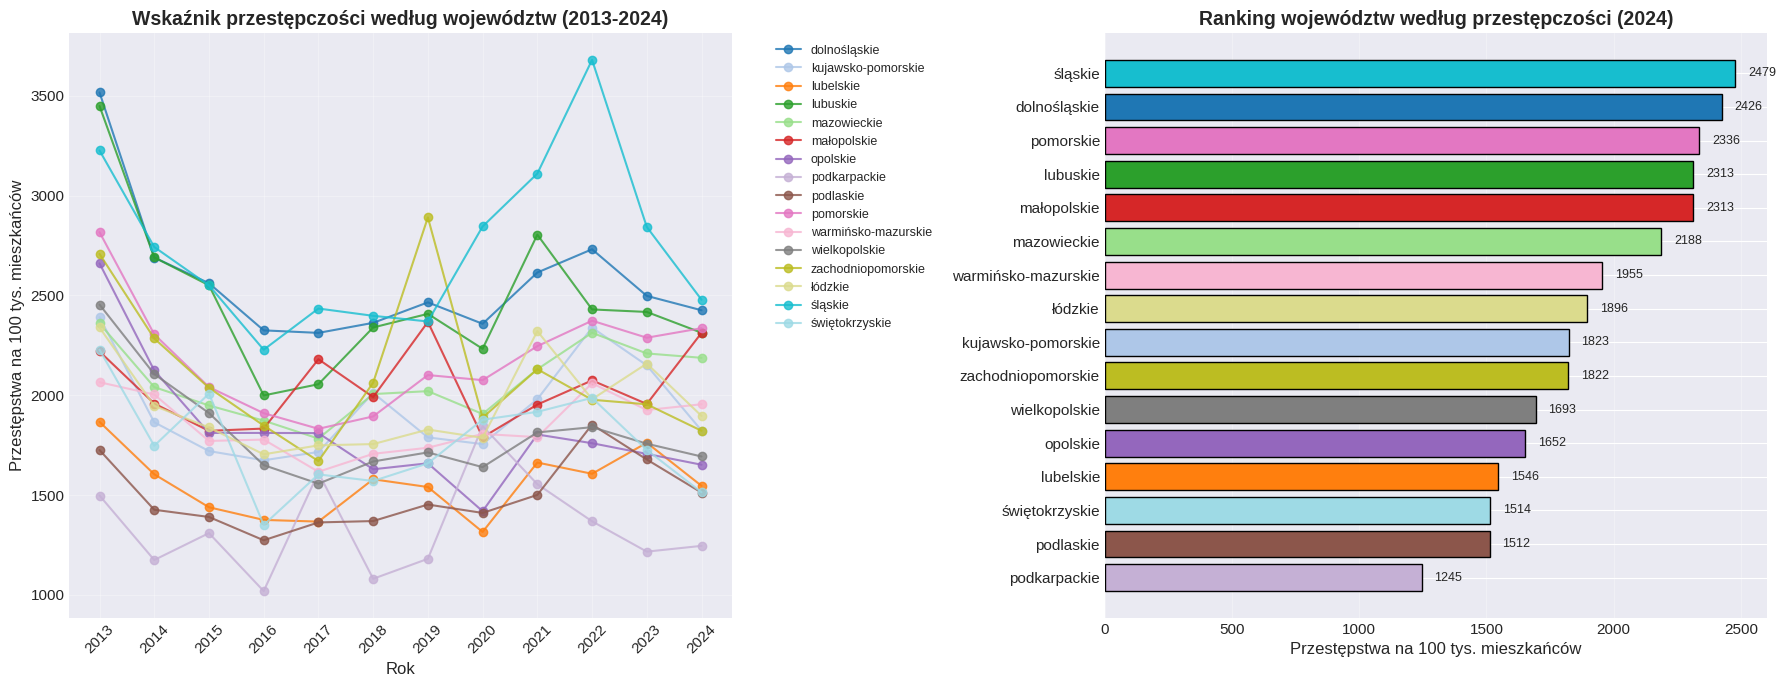


✓ Wykres zapisany jako 'trendy_wojewodztwa.png'


In [57]:
# Wykres liniowy - wszystkie województwa
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax1 = axes[0]

wojewodztwa_list = [w for w in wojewodztwa_yearly['wojewodztwo'].unique() if pd.notna(w)]
colors_palette = plt.cm.tab20(np.linspace(0, 1, len(wojewodztwa_list)))
woj_colors = dict(zip(wojewodztwa_list, colors_palette))

for woj in wojewodztwa_list:
    woj_data = wojewodztwa_yearly[wojewodztwa_yearly['wojewodztwo'] == woj]
    ax1.plot(woj_data['year'], woj_data['crime_rate_per_100k'], 
            marker='o', linewidth=1.5, label=woj, alpha=0.8, color=woj_colors[woj])

ax1.set_title('Wskaźnik przestępczości według województw (2013-2024)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(wojewodztwa_yearly['year'].unique())
ax1.set_xticklabels(wojewodztwa_yearly['year'].unique(), rotation=45)

# Wykres słupkowy - ranking 2024
ax2 = axes[1]
wojewodztwa_2024_sorted = wojewodztwa_2024.sort_values('crime_rate_per_100k')

# Используем те же цвета что и на линейном графике для согласованности
bar_colors = [woj_colors[woj] for woj in wojewodztwa_2024_sorted['wojewodztwo']]

ax2.barh(wojewodztwa_2024_sorted['wojewodztwo'], 
        wojewodztwa_2024_sorted['crime_rate_per_100k'],
        color=bar_colors, edgecolor='black')
ax2.set_title('Ranking województw według przestępczości (2024)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Dodanie wartości na wykresie
for i, (woj, val) in enumerate(zip(wojewodztwa_2024_sorted['wojewodztwo'], 
                                    wojewodztwa_2024_sorted['crime_rate_per_100k'])):
    ax2.text(val + 50, i, f'{val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('./output/imgs/trendy_wojewodztwa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_wojewodztwa.png'")

In [58]:
print("\n" + "="*80)
print("PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH")
print("="*80)

# Ogólny trend
first_year = yearly_stats.iloc[0]
last_year = yearly_stats.iloc[-1]
total_change = ((last_year['crime_rate_per_100k'] - first_year['crime_rate_per_100k']) / 
                first_year['crime_rate_per_100k'] * 100)

print(f"\n📊 POLSKA OGÓŁEM:")
print(f"   Wskaźnik przestępczości {int(first_year['year'])}: {first_year['crime_rate_per_100k']:.0f}")
print(f"   Wskaźnik przestępczości {int(last_year['year'])}: {last_year['crime_rate_per_100k']:.0f}")
print(f"   Zmiana całkowita: {total_change:+.1f}%")

# Rok z najwyższą i najniższą przestępczością
max_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmax()]
min_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmin()]

print(f"\n   Rok z najwyższą przestępczością: {int(max_crime_year['year'])} ({max_crime_year['crime_rate_per_100k']:.0f})")
print(f"   Rok z najniższą przestępczością: {int(min_crime_year['year'])} ({min_crime_year['crime_rate_per_100k']:.0f})")

# Trend bezrobocia
unemployment_change = ((last_year['unemployment_rate'] - first_year['unemployment_rate']) / 
                      first_year['unemployment_rate'] * 100)
print(f"\n📉 BEZROBOCIE:")
print(f"   Stopa bezrobocia {int(first_year['year'])}: {first_year['unemployment_rate']:.1f}%")
print(f"   Stopa bezrobocia {int(last_year['year'])}: {last_year['unemployment_rate']:.1f}%")
print(f"   Zmiana: {unemployment_change:+.1f}%")

print("\n" + "="*80)
print("CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe")
print("="*80)


PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH

📊 POLSKA OGÓŁEM:
   Wskaźnik przestępczości 2013: 2296
   Wskaźnik przestępczości 2024: 1855
   Zmiana całkowita: -19.2%

   Rok z najwyższą przestępczością: 2013 (2296)
   Rok z najniższą przestępczością: 2016 (1621)

📉 BEZROBOCIE:
   Stopa bezrobocia 2013: 16.0%
   Stopa bezrobocia 2024: 6.9%
   Zmiana: -56.7%

CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe


KATEGORII PRZESTĘPSTW

In [59]:
print("="*80)
print("ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII")
print("="*80)

# Wczytanie danych - KODY JAKO STRING!
df_crime_counts = pd.read_csv('./output/crime/crime_counts_powiaty.csv', dtype={'region_code': str})
df_socioeconomic = pd.read_csv('./output/socio/economic_powiaty.csv', dtype={'powiat_code': str})
df_population = pd.read_csv('./output/population/population_with_density.csv', dtype={'powiat_code': str})

print(f"\n✓ Wczytano crime_counts: {df_crime_counts.shape}")
print(f"✓ Wczytano socioeconomic: {df_socioeconomic.shape}")
print(f"✓ Wczytano population: {df_population.shape}")

# Sprawdzenie dostępnych kategorii
crime_categories = df_crime_counts['crime_category'].unique()
print(f"\n--- Dostępne kategorie przestępstw ({len(crime_categories)}) ---")
for i, cat in enumerate(crime_categories, 1):
    count = len(df_crime_counts[df_crime_counts['crime_category'] == cat])
    print(f"{i}. {cat:20s} - {count} rekordów")

# Mapowanie nazw kategorii na polskie
category_names_pl = {
    'criminal': 'Przestępstwa kryminalne',
    'economic': 'Przestępstwa gospodarcze',
    'traffic': 'Przestępstwa drogowe',
    'life_health': 'Przeciwko życiu i zdrowiu',
    'property': 'Przeciwko mieniu',
    'freedom_sexual': 'Przeciwko wolności seksualnej',
    'family': 'Przeciwko rodzinie',
    'public_safety': 'Przeciwko bezpieczeństwu publicznemu'
}

ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII

✓ Wczytano crime_counts: (28512, 5)
✓ Wczytano socioeconomic: (4752, 5)
✓ Wczytano population: (4560, 6)

--- Dostępne kategorie przestępstw (6) ---
1. economic             - 4752 rekordów
2. family               - 4752 rekordów
3. freedom_sexual       - 4752 rekordów
4. life_health          - 4752 rekordów
5. property             - 4752 rekordów
6. traffic              - 4752 rekordów


In [60]:
print("\n" + "="*80)
print("PRZYGOTOWANIE DANYCH - NORMALIZACJA NA 100k MIESZKAŃCÓW")
print("="*80)

# Merge crime counts z population
df_merged = df_crime_counts.merge(
    df_population[['powiat_code', 'powiat_name', 'year', 'total_population']],
    left_on=['region_code', 'year'],
    right_on=['powiat_code', 'year'],
    how='left'
)

# Obliczenie crime rate per 100k dla każdej kategorii
df_merged['crime_rate_per_100k'] = (df_merged['value'] / df_merged['total_population']) * 100000

print(f"\n✓ Dataset po merge: {df_merged.shape}")
print(f"✓ Utworzono wskaźnik crime_rate_per_100k dla każdej kategorii")

# Sprawdzenie braków
missing_pop = df_merged['total_population'].isnull().sum()
print(f"\nBraki w total_population: {missing_pop} ({missing_pop/len(df_merged)*100:.1f}%)")

# Usunięcie braków
df_merged = df_merged.dropna(subset=['total_population', 'crime_rate_per_100k'])
print(f"✓ Po usunięciu braków: {df_merged.shape}")



PRZYGOTOWANIE DANYCH - NORMALIZACJA NA 100k MIESZKAŃCÓW

✓ Dataset po merge: (28512, 9)
✓ Utworzono wskaźnik crime_rate_per_100k dla każdej kategorii

Braki w total_population: 1152 (4.0%)
✓ Po usunięciu braków: (27360, 9)


In [61]:
print("\n" + "="*80)
print("PORÓWNANIE KATEGORII PRZESTĘPSTW - STATYSTYKI OGÓLNE")
print("="*80)

# Agregacja po kategoriach
category_stats = df_merged.groupby('crime_category').agg({
    'value': ['sum', 'mean'],
    'crime_rate_per_100k': ['mean', 'median', 'std']
}).round(2)

category_stats.columns = ['total_crimes', 'avg_crimes', 'avg_rate', 'median_rate', 'std_rate']
category_stats = category_stats.sort_values('avg_rate', ascending=False)

print("\n--- Statystyki według kategorii ---")
print(category_stats)

# Udział procentowy każdej kategorii
total_all_crimes = category_stats['total_crimes'].sum()
category_stats['share_pct'] = (category_stats['total_crimes'] / total_all_crimes * 100).round(1)

print("\n--- Udział procentowy kategorii w ogólnej przestępczości ---")
print(category_stats[['total_crimes', 'share_pct']].sort_values('share_pct', ascending=False))


PORÓWNANIE KATEGORII PRZESTĘPSTW - STATYSTYKI OGÓLNE

--- Statystyki według kategorii ---
                total_crimes  avg_crimes  avg_rate  median_rate  std_rate
crime_category                                                           
property           4967584.0     1089.38    910.04       766.89    646.60
economic           2349106.0      515.15    482.64       311.01    868.55
traffic             908456.0      199.22    222.72       204.28     93.86
family              563396.0      123.55    133.74       114.08     83.07
freedom_sexual      414689.0       90.94     85.32        75.10     90.16
life_health         201061.0       44.09     43.33        39.72     21.19

--- Udział procentowy kategorii w ogólnej przestępczości ---
                total_crimes  share_pct
crime_category                         
property           4967584.0       52.8
economic           2349106.0       25.0
traffic             908456.0        9.7
family              563396.0        6.0
freedom_sexual 

/tmp/ipykernel_26538/2516904519.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot, labels=[category_names_pl.get(cat, cat)[:15] for cat in category_stats.index],


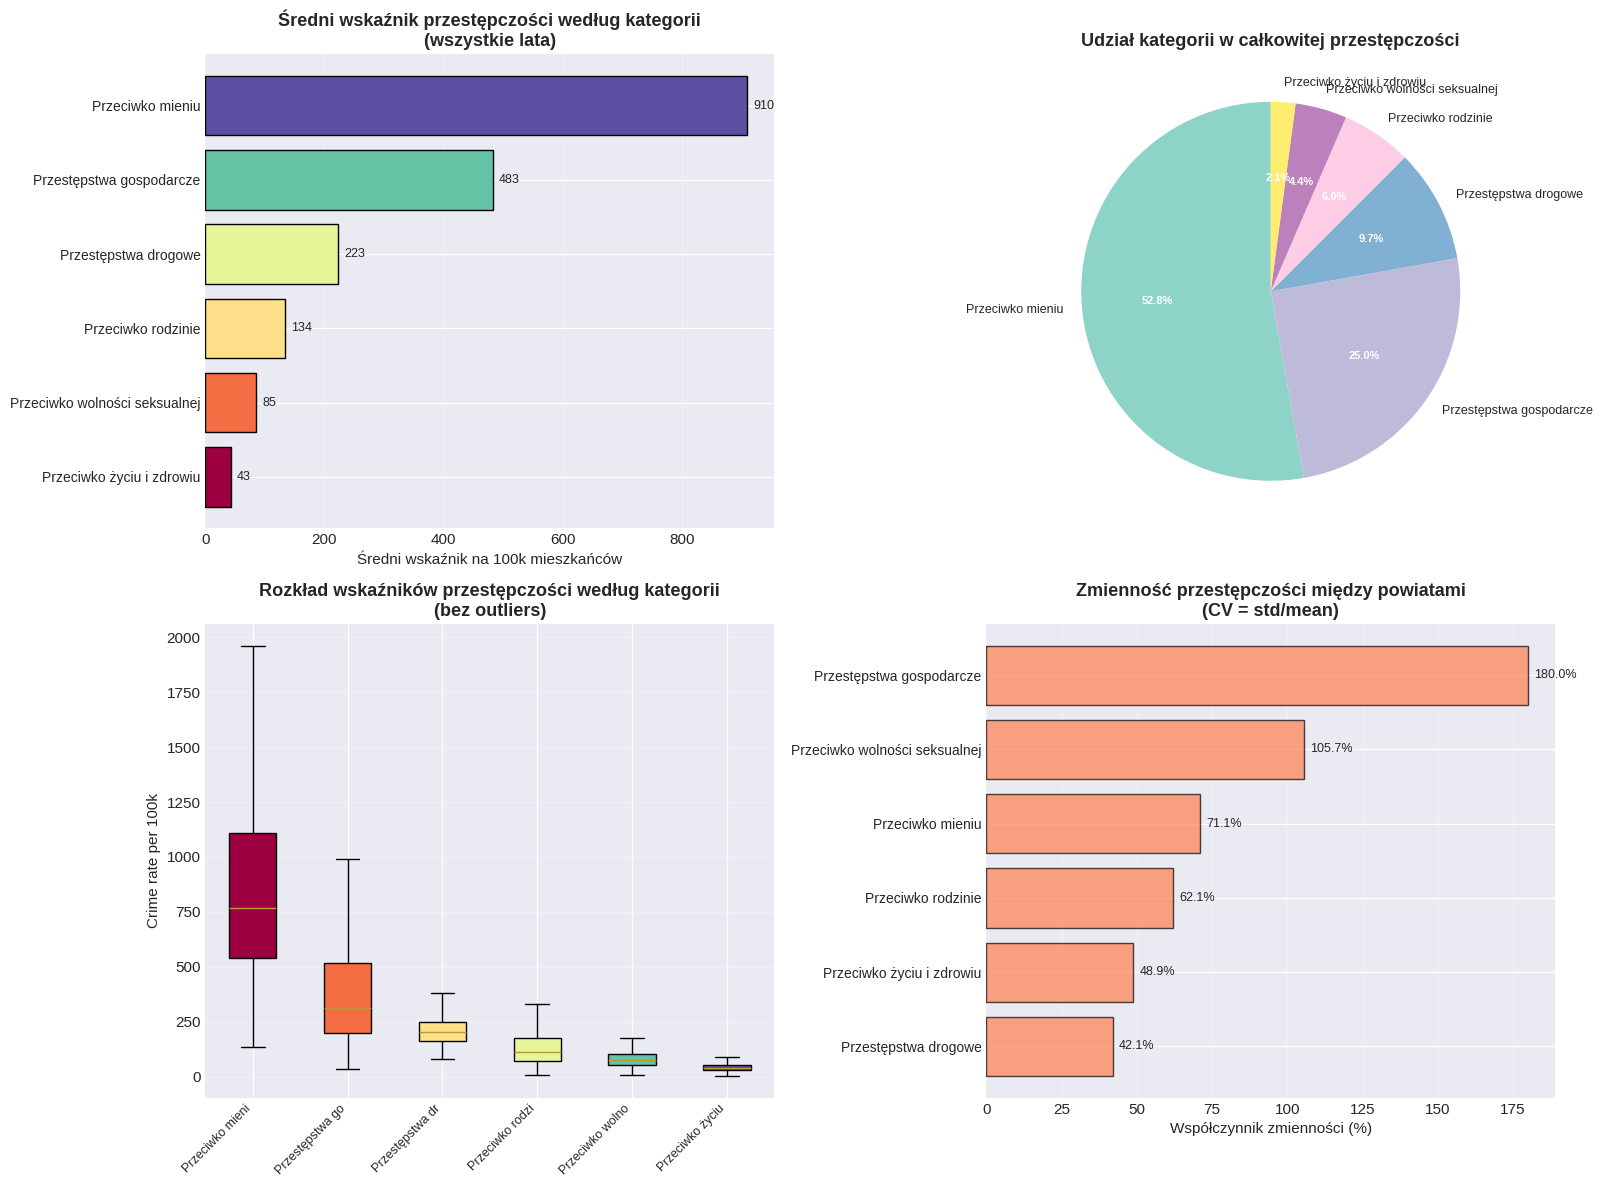


✓ Wykres zapisany jako 'crime_categories_overview.png'


In [62]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Średni wskaźnik według kategorii
ax1 = axes[0, 0]
sorted_cats = category_stats.sort_values('avg_rate', ascending=True)
colors = plt.cm.Spectral(np.linspace(0, 1, len(sorted_cats)))
bars = ax1.barh(range(len(sorted_cats)), sorted_cats['avg_rate'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(sorted_cats)))
ax1.set_yticklabels([category_names_pl.get(cat, cat) for cat in sorted_cats.index], fontsize=10)
ax1.set_xlabel('Średni wskaźnik na 100k mieszkańców', fontsize=11)
ax1.set_title('Średni wskaźnik przestępczości według kategorii\n(wszystkie lata)', 
             fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Dodanie wartości na wykresie
for i, (cat, val) in enumerate(zip(sorted_cats.index, sorted_cats['avg_rate'])):
    ax1.text(val + 10, i, f'{val:.0f}', va='center', fontsize=9)

# Wykres 2: Udział procentowy kategorii
ax2 = axes[0, 1]
share_sorted = category_stats.sort_values('share_pct', ascending=False)
colors2 = plt.cm.Set3(np.linspace(0, 1, len(share_sorted)))
wedges, texts, autotexts = ax2.pie(share_sorted['share_pct'], 
                                     labels=[category_names_pl.get(cat, cat) for cat in share_sorted.index],
                                     autopct='%1.1f%%',
                                     colors=colors2,
                                     startangle=90)
ax2.set_title('Udział kategorii w całkowitej przestępczości', 
             fontsize=13, fontweight='bold')
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

# Wykres 3: Box plot - rozkład wskaźników
ax3 = axes[1, 0]
data_for_boxplot = [df_merged[df_merged['crime_category']==cat]['crime_rate_per_100k'].values 
                    for cat in category_stats.index]
bp = ax3.boxplot(data_for_boxplot, labels=[category_names_pl.get(cat, cat)[:15] for cat in category_stats.index],
                 patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax3.set_ylabel('Crime rate per 100k', fontsize=11)
ax3.set_title('Rozkład wskaźników przestępczości według kategorii\n(bez outliers)', 
             fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

# Wykres 4: Zmienność (CV - coefficient of variation)
ax4 = axes[1, 1]
category_stats['cv'] = (category_stats['std_rate'] / category_stats['avg_rate'] * 100).round(1)
cv_sorted = category_stats.sort_values('cv', ascending=True)
ax4.barh(range(len(cv_sorted)), cv_sorted['cv'], color='coral', edgecolor='black', alpha=0.7)
ax4.set_yticks(range(len(cv_sorted)))
ax4.set_yticklabels([category_names_pl.get(cat, cat) for cat in cv_sorted.index], fontsize=10)
ax4.set_xlabel('Współczynnik zmienności (%)', fontsize=11)
ax4.set_title('Zmienność przestępczości między powiatami\n(CV = std/mean)', 
             fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for i, val in enumerate(cv_sorted['cv']):
    ax4.text(val + 2, i, f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('./output/imgs/crime_categories_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'crime_categories_overview.png'")


TRENDY CZASOWE WEDŁUG KATEGORII

--- Zmiana wskaźników (pierwszy vs ostatni rok) ---

Przestępstwa gospodarcze:
  2013: 398.3
  2024: 585.3
  Zmiana: +47.0%

Przeciwko rodzinie:
  2013: 97.3
  2024: 127.7
  Zmiana: +31.3%

Przeciwko wolności seksualnej:
  2013: 99.1
  2024: 81.1
  Zmiana: -18.2%

Przeciwko życiu i zdrowiu:
  2013: 64.8
  2024: 34.2
  Zmiana: -47.2%

Przeciwko mieniu:
  2013: 1211.7
  2024: 850.7
  Zmiana: -29.8%

Przestępstwa drogowe:
  2013: 425.1
  2024: 176.0
  Zmiana: -58.6%


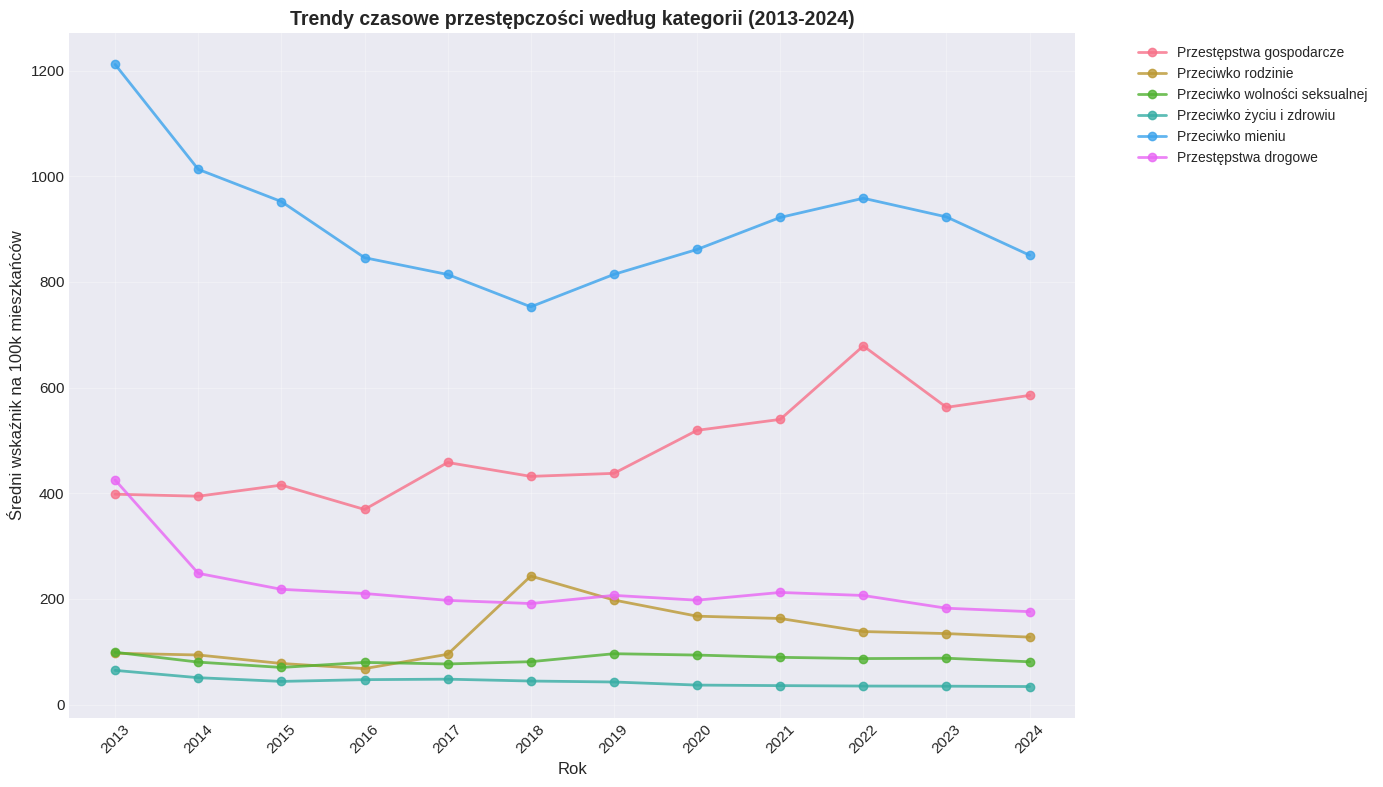


✓ Wykres zapisany jako 'crime_categories_trends.png'


In [63]:
print("\n" + "="*80)
print("TRENDY CZASOWE WEDŁUG KATEGORII")
print("="*80)

# Agregacja roczna dla każdej kategorii
yearly_by_category = df_merged.groupby(['year', 'crime_category'])['crime_rate_per_100k'].mean().reset_index()

# Statystyki zmian w czasie
print("\n--- Zmiana wskaźników (pierwszy vs ostatni rok) ---")
for cat in crime_categories:
    cat_data = yearly_by_category[yearly_by_category['crime_category'] == cat].sort_values('year')
    if len(cat_data) > 0:
        first_year_val = cat_data.iloc[0]['crime_rate_per_100k']
        last_year_val = cat_data.iloc[-1]['crime_rate_per_100k']
        change_pct = ((last_year_val - first_year_val) / first_year_val * 100) if first_year_val > 0 else 0
        
        print(f"\n{category_names_pl.get(cat, cat)}:")
        print(f"  {int(cat_data.iloc[0]['year'])}: {first_year_val:.1f}")
        print(f"  {int(cat_data.iloc[-1]['year'])}: {last_year_val:.1f}")
        print(f"  Zmiana: {change_pct:+.1f}%")

# Wizualizacja trendów
fig, ax = plt.subplots(figsize=(14, 8))

for cat in crime_categories:
    cat_data = yearly_by_category[yearly_by_category['crime_category'] == cat].sort_values('year')
    ax.plot(cat_data['year'], cat_data['crime_rate_per_100k'], 
           marker='o', linewidth=2, label=category_names_pl.get(cat, cat), alpha=0.8)

ax.set_xlabel('Rok', fontsize=12)
ax.set_ylabel('Średni wskaźnik na 100k mieszkańców', fontsize=12)
ax.set_title('Trendy czasowe przestępczości według kategorii (2013-2024)', 
            fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(yearly_by_category['year'].unique())
ax.set_xticklabels(yearly_by_category['year'].unique(), rotation=45)

plt.tight_layout()
plt.savefig('./output/imgs/crime_categories_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'crime_categories_trends.png'")


KORELACJE SPOŁECZNO-EKONOMICZNE DLA KAŻDEJ KATEGORII

✓ Dataset z danymi socjoekonomicznymi: (20808, 12)

--- Korelacje crime_rate z czynnikami społeczno-ekonomicznymi ---

Przestępstwa gospodarcze:
  population_density  : r=+0.182 ***
  unemployment_rate   : r=-0.118 ***
  wage_index          : r=+0.081 ***

Przeciwko rodzinie:
  population_density  : r=+0.016 
  unemployment_rate   : r=-0.126 ***
  wage_index          : r=+0.002 

Przeciwko wolności seksualnej:
  population_density  : r=+0.105 ***
  unemployment_rate   : r=-0.030 
  wage_index          : r=+0.091 ***

Przeciwko życiu i zdrowiu:
  population_density  : r=+0.297 ***
  unemployment_rate   : r=+0.215 ***
  wage_index          : r=+0.207 ***

Przeciwko mieniu:
  population_density  : r=+0.468 ***
  unemployment_rate   : r=-0.107 ***
  wage_index          : r=+0.313 ***

Przestępstwa drogowe:
  population_density  : r=-0.266 ***
  unemployment_rate   : r=+0.433 ***
  wage_index          : r=-0.143 ***



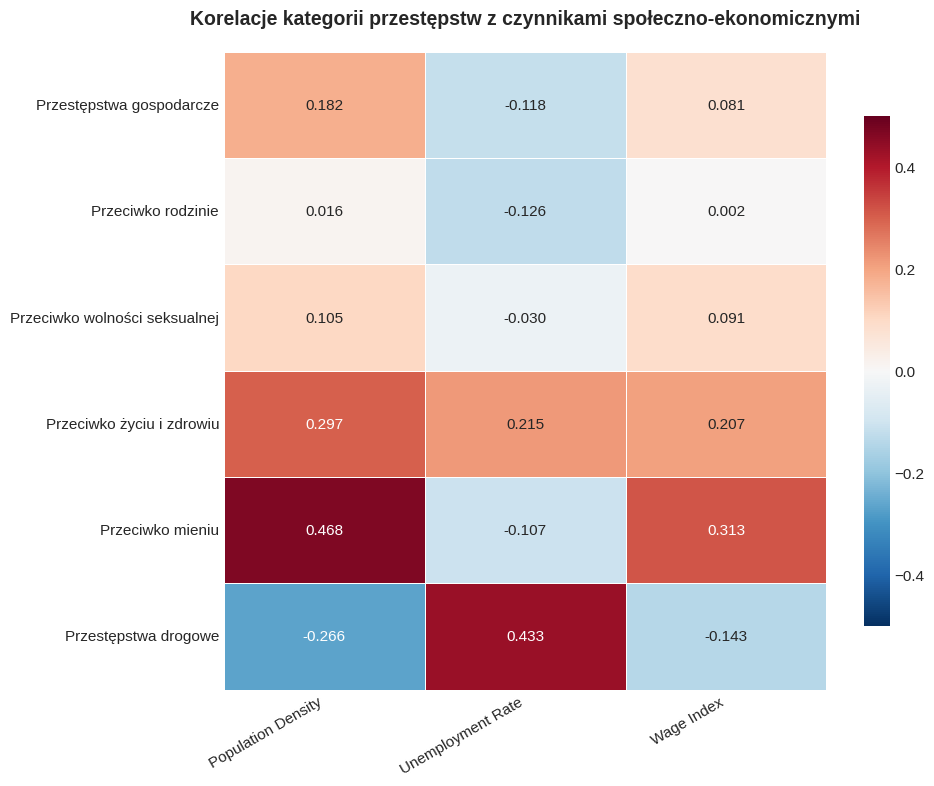


✓ Heatmapa korelacji zapisana jako 'crime_categories_correlations_heatmap.png'


In [64]:
print("\n" + "="*80)
print("KORELACJE SPOŁECZNO-EKONOMICZNE DLA KAŻDEJ KATEGORII")
print("="*80)

# Merge z danymi socjoekonomicznymi
df_with_socio = df_merged.merge(
    df_socioeconomic[['powiat_code', 'year', 'unemployment_rate', 'wage_index']],
    on=['powiat_code', 'year'],
    how='left'
)

# Merge z danymi demograficznymi
df_with_socio = df_with_socio.merge(
    df_population[['powiat_code', 'year', 'population_density']],
    on=['powiat_code', 'year'],
    how='left'
)

# Usunięcie braków
df_with_socio = df_with_socio.dropna(subset=['unemployment_rate', 'wage_index', 'population_density'])

print(f"\n✓ Dataset z danymi socjoekonomicznymi: {df_with_socio.shape}")

# Obliczanie korelacji dla każdej kategorii
socio_features = ['population_density', 'unemployment_rate', 'wage_index']
correlation_matrix_by_category = pd.DataFrame(index=crime_categories, columns=socio_features)

print("\n--- Korelacje crime_rate z czynnikami społeczno-ekonomicznymi ---\n")

for cat in crime_categories:
    cat_data = df_with_socio[df_with_socio['crime_category'] == cat]
    
    print(f"{category_names_pl.get(cat, cat)}:")
    
    for feature in socio_features:
        corr = cat_data[['crime_rate_per_100k', feature]].corr().iloc[0, 1]
        correlation_matrix_by_category.loc[cat, feature] = corr
        
        # Test istotności
        corr_coef, p_value = stats.pearsonr(cat_data['crime_rate_per_100k'].dropna(), 
                                            cat_data[cat_data['crime_rate_per_100k'].notna()][feature])
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        print(f"  {feature:20s}: r={corr:+.3f} {sig}")
    print()

# Konwersja na numeryczne
correlation_matrix_by_category = correlation_matrix_by_category.astype(float)

# Wizualizacja heatmapy korelacji
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix_by_category, 
            annot=True, 
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            vmin=-0.5, vmax=0.5,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            xticklabels=[f.replace('_', ' ').title() for f in socio_features],
            yticklabels=[category_names_pl.get(cat, cat) for cat in crime_categories],
            ax=ax)

ax.set_title('Korelacje kategorii przestępstw z czynnikami społeczno-ekonomicznymi', 
            fontsize=14, fontweight='bold', pad=20)
plt.yticks(rotation=0)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.savefig('./output/imgs/crime_categories_correlations_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmapa korelacji zapisana jako 'crime_categories_correlations_heatmap.png'")

Korelacje społeczno-ekonomiczne dla każdej kategorii

In [65]:
print("\n" + "="*80)
print("TOP-10 POWIATÓW WEDŁUG KATEGORII PRZESTĘPSTW (2024)")
print("="*80)

# Filtrowanie danych z 2024 roku
df_2024_categories = df_merged[df_merged['year'] == 2024].copy()

# Dla każdej kategorii - top 10
for cat in crime_categories:
    cat_data = df_2024_categories[df_2024_categories['crime_category'] == cat]
    top10 = cat_data.nlargest(10, 'crime_rate_per_100k')[['powiat_name', 'crime_rate_per_100k']]
    
    print(f"\n--- {category_names_pl.get(cat, cat).upper()} - TOP 10 (2024) ---")
    for i, (idx, row) in enumerate(top10.iterrows(), 1):
        print(f"{i:2d}. {row['powiat_name']:30s} - {row['crime_rate_per_100k']:7.1f}")


TOP-10 POWIATÓW WEDŁUG KATEGORII PRZESTĘPSTW (2024)

--- PRZESTĘPSTWA GOSPODARCZE - TOP 10 (2024) ---
 1. Powiat nowosądecki             -  9566.9
 2. Powiat ostrołęcki              -  8308.1
 3. Powiat m. Siemianowice Śląskie -  4643.6
 4. Powiat m. Żory                 -  3554.4
 5. Powiat m. Dąbrowa Górnicza     -  2704.4
 6. Powiat nowotomyski             -  2624.8
 7. Powiat pabianicki              -  2549.2
 8. Powiat bartoszycki             -  2450.0
 9. Powiat myszkowski              -  2177.5
10. Powiat m. Konin                -  2093.7

--- PRZECIWKO RODZINIE - TOP 10 (2024) ---
 1. Powiat starachowicki           -   343.5
 2. Powiat skarżyski               -   285.9
 3. Powiat parczewski              -   282.7
 4. Powiat m. Wałbrzych od 2013    -   278.5
 5. Powiat hrubieszowski           -   277.2
 6. Powiat m. Piekary Śląskie      -   276.4
 7. Powiat lwówecki                -   270.8
 8. Powiat m. Bytom                -   252.2
 9. Powiat nowodworski             -   248.

Korelacja przestępczości z wykrywalnością (detection rates)

In [66]:
print("\n" + "="*80)
print("KORELACJA PRZESTĘPCZOŚCI Z WYKRYWALNOŚCIĄ (DETECTION RATES)")
print("="*80)

# Wczytanie danych z prawidłowym typem region_code jako string
df_crime_counts_det = pd.read_csv('./output/crime/crime_counts_powiaty.csv', dtype={'region_code': str})
df_crime_detection_det = pd.read_csv('./output/crime/crime_detection_rates_powiaty.csv', dtype={'region_code': str})

# Filtrujemy tylko powiaty (bez województw)
df_counts_powiaty = df_crime_counts_det[~df_crime_counts_det['region_code'].str.endswith('00000')].copy()
df_detection_powiaty = df_crime_detection_det[~df_crime_detection_det['region_code'].str.endswith('00000')].copy()

# Merge crime_counts z crime_detection
df_detection_analysis = df_counts_powiaty.merge(
    df_detection_powiaty,
    on=['region_code', 'year', 'crime_category'],
    how='inner',
    suffixes=('_count', '_detection')
)

# Zmiana nazw kolumn dla czytelności
df_detection_analysis = df_detection_analysis.rename(columns={
    'value_count': 'crime_count',
    'value_detection': 'detection_rate'
})

# Merge z population dla crime_rate_per_100k
df_population_det = pd.read_csv('./output/population/population_with_density.csv', dtype={'powiat_code': str})
df_detection_analysis = df_detection_analysis.merge(
    df_population_det[['powiat_code', 'year', 'total_population']],
    left_on=['region_code', 'year'],
    right_on=['powiat_code', 'year'],
    how='left'
)

# Obliczenie crime rate per 100k
df_detection_analysis['crime_rate_per_100k'] = (
    df_detection_analysis['crime_count'] / df_detection_analysis['total_population'] * 100000
)

# Usunięcie braków
df_detection_analysis = df_detection_analysis.dropna(subset=['crime_rate_per_100k', 'detection_rate'])

print(f"\n✓ Połączono dane o przestępczości z wykrywalnością: {df_detection_analysis.shape}")
print(f"✓ Kategorie: {df_detection_analysis['crime_category'].unique().tolist()}")

# Korelacja ogólna
overall_corr = df_detection_analysis[['crime_rate_per_100k', 'detection_rate']].corr().iloc[0, 1]
corr_coef, p_value = stats.pearsonr(
    df_detection_analysis['crime_rate_per_100k'],
    df_detection_analysis['detection_rate']
)

print(f"\n--- KORELACJA OGÓLNA ---")
print(f"Korelacja crime_rate vs detection_rate: r = {overall_corr:.3f}")
print(f"p-value: {p_value:.6f}")
sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
print(f"Istotność: {sig if sig else 'nieistotna'}")

# Korelacja dla każdej kategorii
print("\n--- KORELACJA WEDŁUG KATEGORII ---\n")

detection_correlations = {}
for cat in df_detection_analysis['crime_category'].unique():
    cat_data = df_detection_analysis[df_detection_analysis['crime_category'] == cat]
    
    corr = cat_data[['crime_rate_per_100k', 'detection_rate']].corr().iloc[0, 1]
    corr_coef, p_val = stats.pearsonr(cat_data['crime_rate_per_100k'], cat_data['detection_rate'])
    
    detection_correlations[cat] = corr
    
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    direction = "↑ dodatnia" if corr > 0 else "↓ ujemna"
    
    print(f"{category_names_pl.get(cat, cat):30s}: r = {corr:+.3f} {sig} ({direction})")


KORELACJA PRZESTĘPCZOŚCI Z WYKRYWALNOŚCIĄ (DETECTION RATES)

✓ Połączono dane o przestępczości z wykrywalnością: (27360, 10)
✓ Kategorie: ['economic', 'family', 'freedom_sexual', 'life_health', 'property', 'traffic']

--- KORELACJA OGÓLNA ---
Korelacja crime_rate vs detection_rate: r = -0.362
p-value: 0.000000
Istotność: ***

--- KORELACJA WEDŁUG KATEGORII ---

Przestępstwa gospodarcze      : r = +0.239 *** (↑ dodatnia)
Przeciwko rodzinie            : r = +0.170 *** (↑ dodatnia)
Przeciwko wolności seksualnej : r = +0.128 *** (↑ dodatnia)
Przeciwko życiu i zdrowiu     : r = -0.239 *** (↓ ujemna)
Przeciwko mieniu              : r = +0.103 *** (↑ dodatnia)
Przestępstwa drogowe          : r = +0.148 *** (↑ dodatnia)


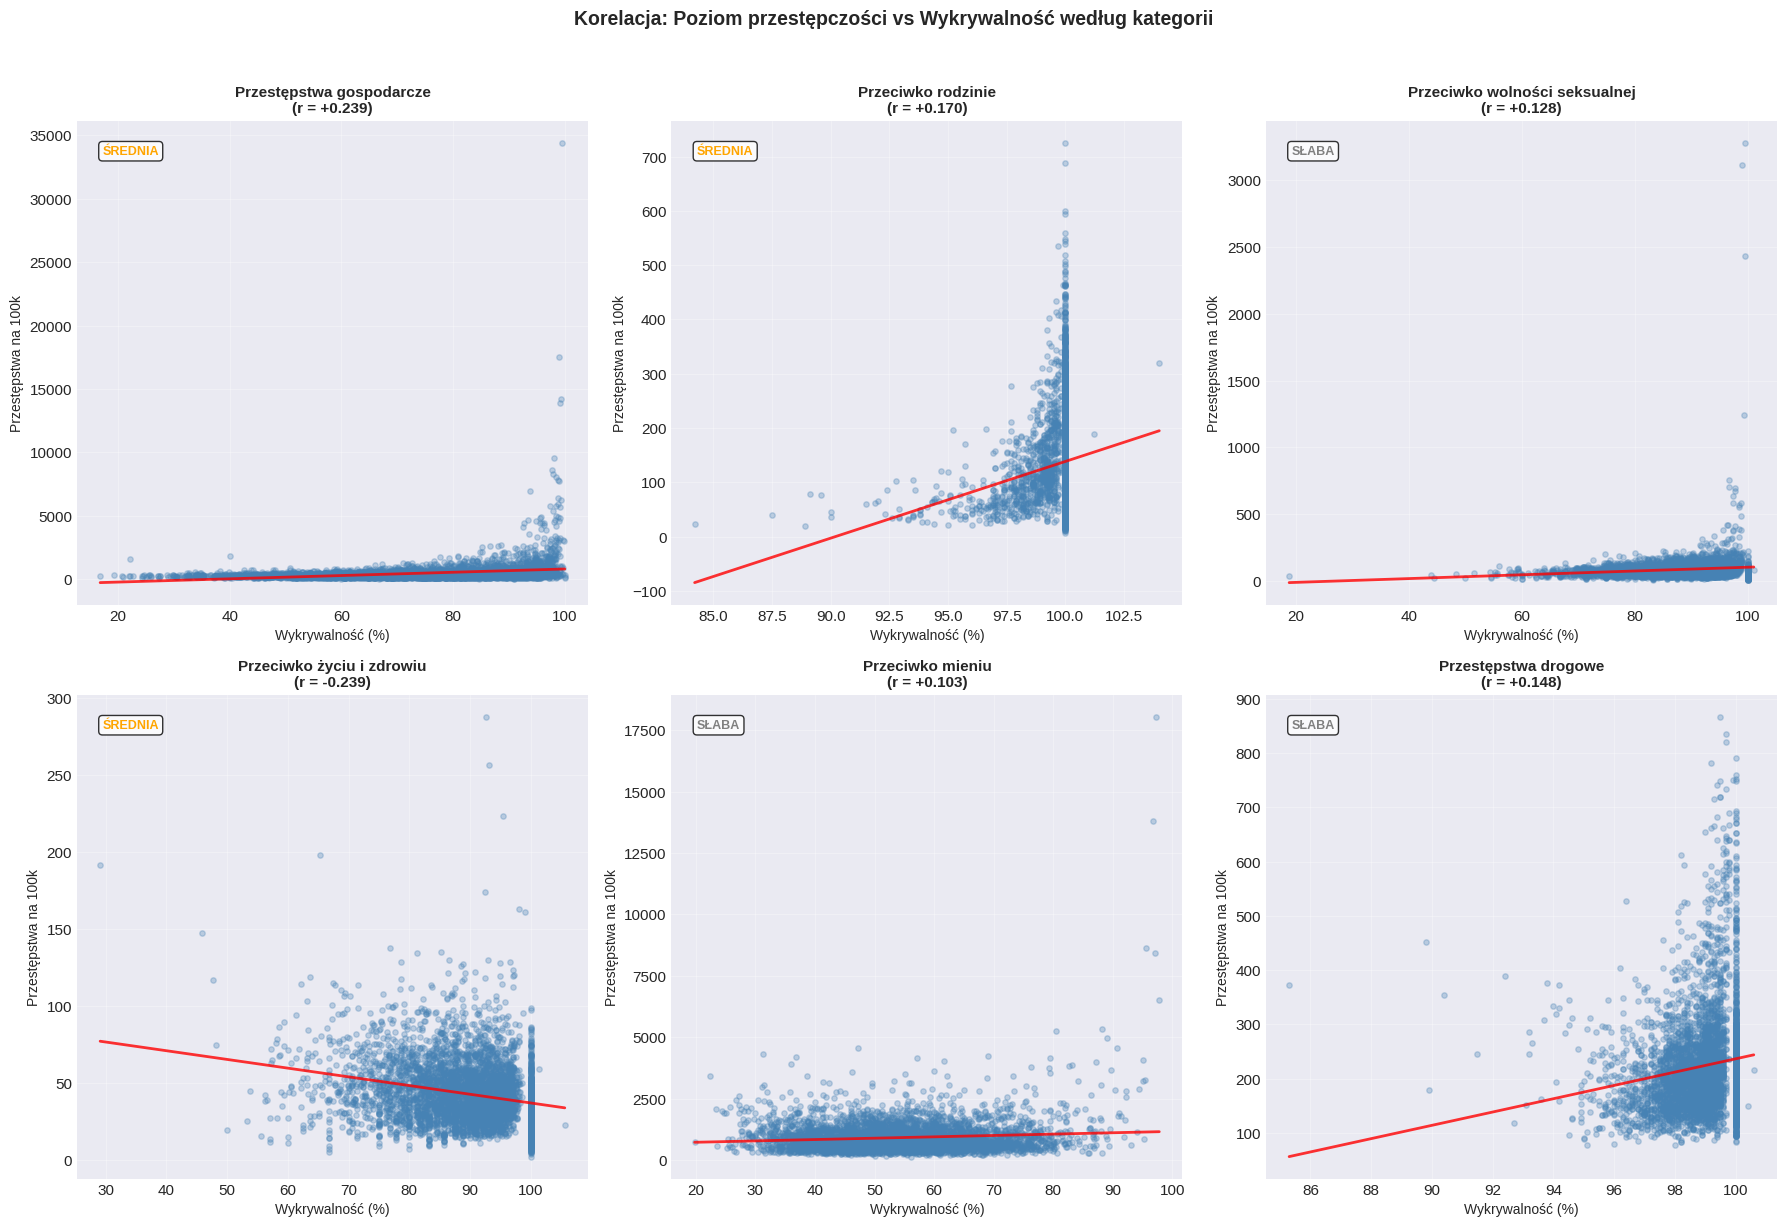


✓ Wykres zapisany jako 'crime_vs_detection_correlation.png'


In [67]:
# Wizualizacja korelacji przestępczość vs wykrywalność
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, cat in enumerate(df_detection_analysis['crime_category'].unique()):
    ax = axes[idx]
    cat_data = df_detection_analysis[df_detection_analysis['crime_category'] == cat]
    
    # Scatter plot
    ax.scatter(cat_data['detection_rate'], cat_data['crime_rate_per_100k'], 
               alpha=0.3, s=15, color='steelblue')
    
    # Linia regresji
    z = np.polyfit(cat_data['detection_rate'], cat_data['crime_rate_per_100k'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(cat_data['detection_rate'].min(), cat_data['detection_rate'].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, alpha=0.8)
    
    # Korelacja
    corr = detection_correlations[cat]
    
    ax.set_title(f'{category_names_pl.get(cat, cat)}\n(r = {corr:+.3f})', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Wykrywalność (%)', fontsize=10)
    ax.set_ylabel('Przestępstwa na 100k', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Oznaczenie siły korelacji
    if abs(corr) > 0.3:
        strength, color = "SILNA", 'red'
    elif abs(corr) > 0.15:
        strength, color = "ŚREDNIA", 'orange'
    else:
        strength, color = "SŁABA", 'gray'
    
    ax.text(0.05, 0.95, f'{strength}', transform=ax.transAxes, fontsize=9,
           verticalalignment='top', color=color, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Korelacja: Poziom przestępczości vs Wykrywalność według kategorii', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./output/imgs/crime_vs_detection_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'crime_vs_detection_correlation.png'")


HEATMAPA: WYKRYWALNOŚĆ VS PRZESTĘPCZOŚĆ I CZYNNIKI SPOŁECZNO-EKONOMICZNE

✓ Przygotowano pełny dataset: (3468, 14)


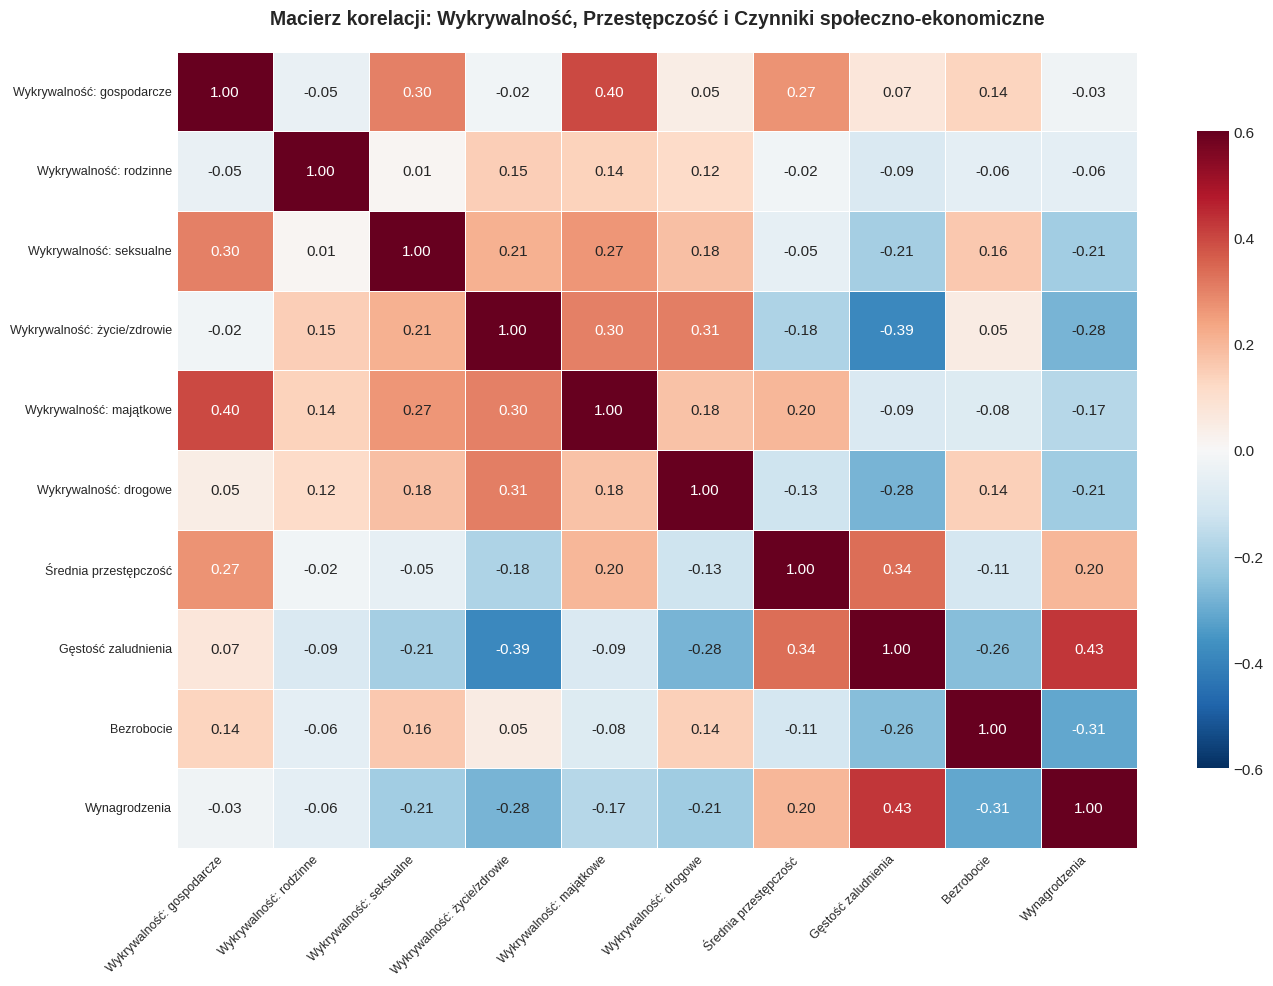


✓ Heatmapa zapisana jako 'detection_full_correlation_heatmap.png'


In [68]:
# Heatmapa korelacji: wykrywalność vs czynniki społeczno-ekonomiczne i przestępczość
print("\n" + "="*80)
print("HEATMAPA: WYKRYWALNOŚĆ VS PRZESTĘPCZOŚĆ I CZYNNIKI SPOŁECZNO-EKONOMICZNE")
print("="*80)

# Pivot detection rates - średnia wykrywalność per powiat/rok
df_detection_pivot = df_detection_analysis.pivot_table(
    index=['region_code', 'year'],
    columns='crime_category',
    values='detection_rate',
    aggfunc='mean'
).reset_index()

# Zmiana nazw kolumn
df_detection_pivot.columns = ['region_code', 'year'] + [f'detection_{cat}' for cat in df_detection_pivot.columns[2:]]

# Wczytanie danych socjoekonomicznych z prawidłowym typem
df_socioeconomic_det = pd.read_csv('./output/socio/economic_powiaty.csv', dtype={'powiat_code': str})

# Merge z danymi socjoekonomicznymi
df_full_analysis = df_detection_pivot.merge(
    df_population_det[['powiat_code', 'year', 'total_population', 'population_density']],
    left_on=['region_code', 'year'],
    right_on=['powiat_code', 'year'],
    how='left'
)

df_full_analysis = df_full_analysis.merge(
    df_socioeconomic_det[['powiat_code', 'year', 'unemployment_rate', 'wage_index']],
    on=['powiat_code', 'year'],
    how='left'
)

# Merge z crime_rate_per_100k (agregowany z df_detection_analysis)
crime_rate_agg = df_detection_analysis.groupby(['region_code', 'year'])['crime_rate_per_100k'].mean().reset_index()
crime_rate_agg.columns = ['region_code', 'year', 'avg_crime_rate']

df_full_analysis = df_full_analysis.merge(
    crime_rate_agg,
    on=['region_code', 'year'],
    how='left'
)

# Usunięcie braków
df_full_analysis = df_full_analysis.dropna()

print(f"\n✓ Przygotowano pełny dataset: {df_full_analysis.shape}")

# Obliczenie macierzy korelacji
detection_cols = [col for col in df_full_analysis.columns if col.startswith('detection_')]
analysis_cols = detection_cols + ['avg_crime_rate', 'population_density', 'unemployment_rate', 'wage_index']

correlation_detection = df_full_analysis[analysis_cols].corr()

# Wizualizacja
fig, ax = plt.subplots(figsize=(14, 10))

# Polskie nazwy dla etykiet
col_names_pl = {
    'detection_economic': 'Wykrywalność: gospodarcze',
    'detection_family': 'Wykrywalność: rodzinne',
    'detection_freedom_sexual': 'Wykrywalność: seksualne',
    'detection_life_health': 'Wykrywalność: życie/zdrowie',
    'detection_property': 'Wykrywalność: majątkowe',
    'detection_traffic': 'Wykrywalność: drogowe',
    'avg_crime_rate': 'Średnia przestępczość',
    'population_density': 'Gęstość zaludnienia',
    'unemployment_rate': 'Bezrobocie',
    'wage_index': 'Wynagrodzenia'
}

labels = [col_names_pl.get(col, col) for col in analysis_cols]

sns.heatmap(correlation_detection, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-0.6, vmax=0.6,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            xticklabels=labels,
            yticklabels=labels,
            ax=ax)

ax.set_title('Macierz korelacji: Wykrywalność, Przestępczość i Czynniki społeczno-ekonomiczne', 
            fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('./output/imgs/detection_full_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmapa zapisana jako 'detection_full_correlation_heatmap.png'")

In [69]:
# Podsumowanie analizy wykrywalności
print("\n" + "="*80)
print("PODSUMOWANIE - ANALIZA WYKRYWALNOŚCI PRZESTĘPSTW")
print("="*80)

print("\n📌 KLUCZOWE WNIOSKI:\n")

# Sortowanie korelacji
sorted_corr = sorted(detection_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("1. KORELACJE PRZESTĘPCZOŚĆ VS WYKRYWALNOŚĆ:")
for cat, corr in sorted_corr:
    direction = "Im wyższa wykrywalność, tym WIĘCEJ przestępstw" if corr > 0 else "Im wyższa wykrywalność, tym MNIEJ przestępstw"
    print(f"   • {category_names_pl.get(cat, cat)}: r={corr:+.3f}")
    if abs(corr) > 0.2:
        print(f"     → {direction}")

# Interpretacja
print("\n2. INTERPRETACJA:")
print("   • Ujemna korelacja = wyższa wykrywalność → mniej przestępstw")
print("     (efekt odstraszający lub sprawna policja)")
print("   • Dodatnia korelacja = więcej przestępstw → wyższa wykrywalność")
print("     (paradoks: łatwiej wykryć tam, gdzie więcej przypadków?)")

# Średnie wykrywalności
print("\n3. ŚREDNIA WYKRYWALNOŚĆ WEDŁUG KATEGORII:")
avg_detection = df_detection_analysis.groupby('crime_category')['detection_rate'].mean().sort_values(ascending=False)
for cat, rate in avg_detection.items():
    print(f"   • {category_names_pl.get(cat, cat):30s}: {rate:.1f}%")

print("\n" + "="*80)
print("SEKCJA ZAKOŃCZONA - Analiza wykrywalności")
print("="*80)


PODSUMOWANIE - ANALIZA WYKRYWALNOŚCI PRZESTĘPSTW

📌 KLUCZOWE WNIOSKI:

1. KORELACJE PRZESTĘPCZOŚĆ VS WYKRYWALNOŚĆ:
   • Przeciwko życiu i zdrowiu: r=-0.239
     → Im wyższa wykrywalność, tym MNIEJ przestępstw
   • Przestępstwa gospodarcze: r=+0.239
     → Im wyższa wykrywalność, tym WIĘCEJ przestępstw
   • Przeciwko rodzinie: r=+0.170
   • Przestępstwa drogowe: r=+0.148
   • Przeciwko wolności seksualnej: r=+0.128
   • Przeciwko mieniu: r=+0.103

2. INTERPRETACJA:
   • Ujemna korelacja = wyższa wykrywalność → mniej przestępstw
     (efekt odstraszający lub sprawna policja)
   • Dodatnia korelacja = więcej przestępstw → wyższa wykrywalność
     (paradoks: łatwiej wykryć tam, gdzie więcej przypadków?)

3. ŚREDNIA WYKRYWALNOŚĆ WEDŁUG KATEGORII:
   • Przeciwko rodzinie            : 99.7%
   • Przestępstwa drogowe          : 98.9%
   • Przeciwko życiu i zdrowiu     : 89.3%
   • Przeciwko wolności seksualnej : 88.1%
   • Przestępstwa gospodarcze      : 75.2%
   • Przeciwko mieniu           

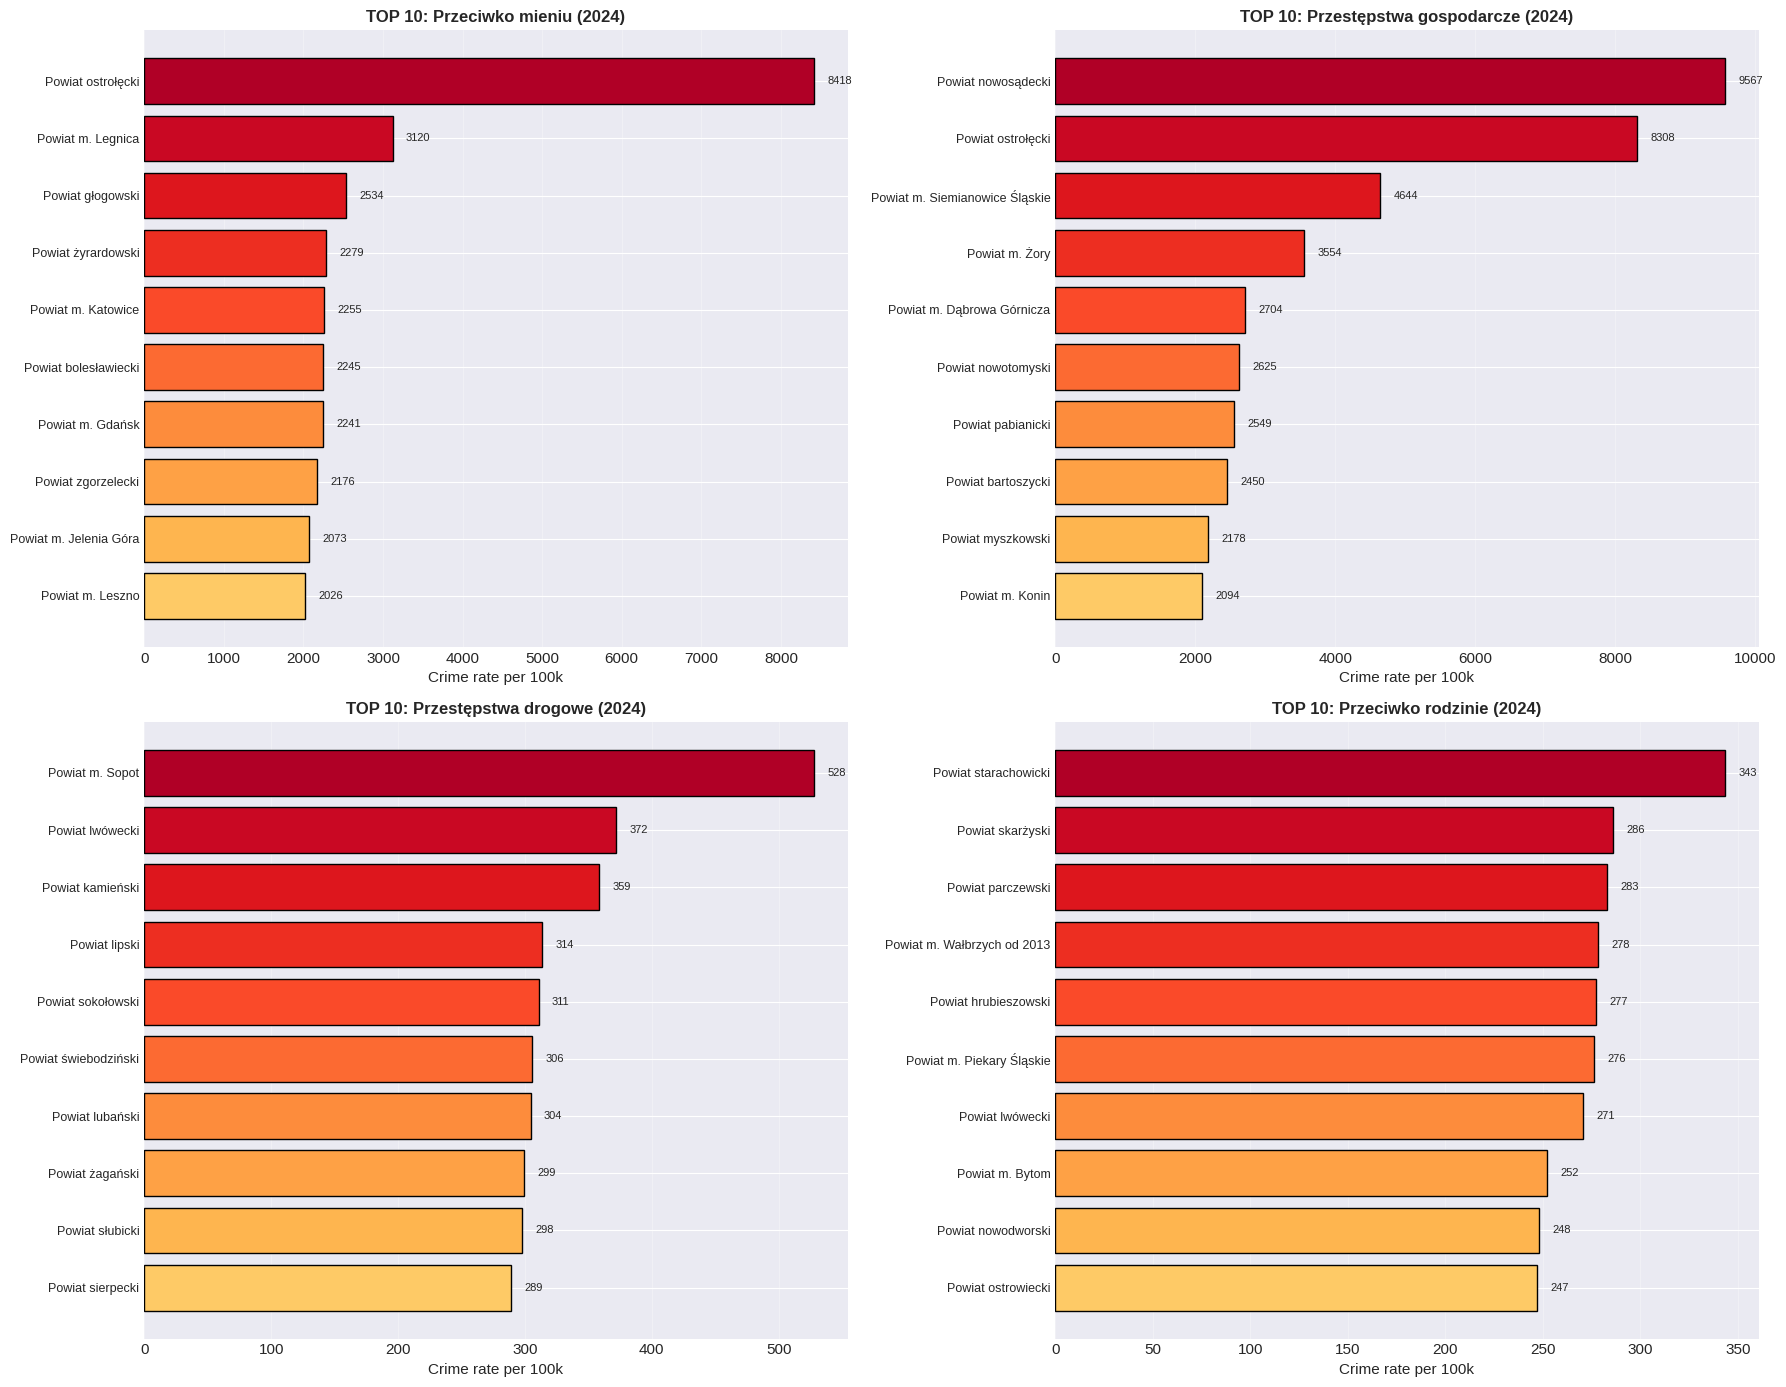


✓ Wykres TOP-10 zapisany jako 'crime_categories_top10_powiaty.png'


In [70]:
top4_categories = category_stats.nlargest(4, 'share_pct').index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, cat in enumerate(top4_categories):
    ax = axes[idx]
    cat_data = df_2024_categories[df_2024_categories['crime_category'] == cat]
    top10 = cat_data.nlargest(10, 'crime_rate_per_100k').sort_values('crime_rate_per_100k')
    
    colors_gradient = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top10)))
    ax.barh(range(len(top10)), top10['crime_rate_per_100k'], color=colors_gradient, edgecolor='black')
    ax.set_yticks(range(len(top10)))
    ax.set_yticklabels(top10['powiat_name'], fontsize=9)
    ax.set_xlabel('Crime rate per 100k', fontsize=11)
    ax.set_title(f'TOP 10: {category_names_pl.get(cat, cat)} (2024)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Dodanie wartości
    for i, val in enumerate(top10['crime_rate_per_100k']):
        ax.text(val + max(top10['crime_rate_per_100k'])*0.02, i, f'{val:.0f}', 
               va='center', fontsize=8)

plt.tight_layout()
plt.savefig('./output/imgs/crime_categories_top10_powiaty.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres TOP-10 zapisany jako 'crime_categories_top10_powiaty.png'")

MODELE

In [71]:
# Target variable
target = 'crime_rate_per_100k'

# Features do analizy
features_numeric = [
    'population_density',          # Gęstość zaludnienia
    'unemployment_rate',           # Bezrobocie
    'wage_index',                  # Wynagrodzenia
    'youth_ratio',                 # Udział młodzieży 15-29
    'middle_age_ratio',            # Udział 30-49 lat
    'elderly_ratio',               # Udział 50-69 lat
    'gender_ratio',                # Mężczyźni na 100 kobiet
    'population_change_pct',       # Zmiana populacji r/r
    'total_population'             # Całkowita populacja
]

# Tworzenie DataFrame tylko z wybranymi kolumnami
df_corr = df_ml_ready[[target] + features_numeric].copy()

print("\n--- Zmienne do analizy korelacji ---")
for i, col in enumerate([target] + features_numeric, 1):
    print(f"{i}. {col}")


--- Zmienne do analizy korelacji ---
1. crime_rate_per_100k
2. population_density
3. unemployment_rate
4. wage_index
5. youth_ratio
6. middle_age_ratio
7. elderly_ratio
8. gender_ratio
9. population_change_pct
10. total_population


In [72]:
print("\n" + "="*80)
print("MACIERZ KORELACJI")
print("="*80)

# Obliczenie macierzy korelacji Pearsona
correlation_matrix = df_corr.corr()

# Korelacje z crime_rate_per_100k
correlations_with_target = correlation_matrix[target].sort_values(ascending=False)

print("\n--- Korelacje z wskaźnikiem przestępczości ---")
print(correlations_with_target)

# Najsilniejsze korelacje (absolutne wartości)
print("\n--- TOP 5 najsilniejszych korelacji (|r|) ---")
abs_correlations = correlations_with_target.abs().sort_values(ascending=False)
print(abs_correlations.head(6)[1:])  # Pomijamy samą zmienną target


MACIERZ KORELACJI

--- Korelacje z wskaźnikiem przestępczości ---
crime_rate_per_100k      1.000000
population_density       0.320118
wage_index               0.190523
elderly_ratio            0.144378
middle_age_ratio         0.133124
total_population         0.098054
population_change_pct   -0.070920
unemployment_rate       -0.141870
youth_ratio             -0.244364
gender_ratio            -0.324862
Name: crime_rate_per_100k, dtype: float64

--- TOP 5 najsilniejszych korelacji (|r|) ---
gender_ratio          0.324862
population_density    0.320118
youth_ratio           0.244364
wage_index            0.190523
elderly_ratio         0.144378
Name: crime_rate_per_100k, dtype: float64


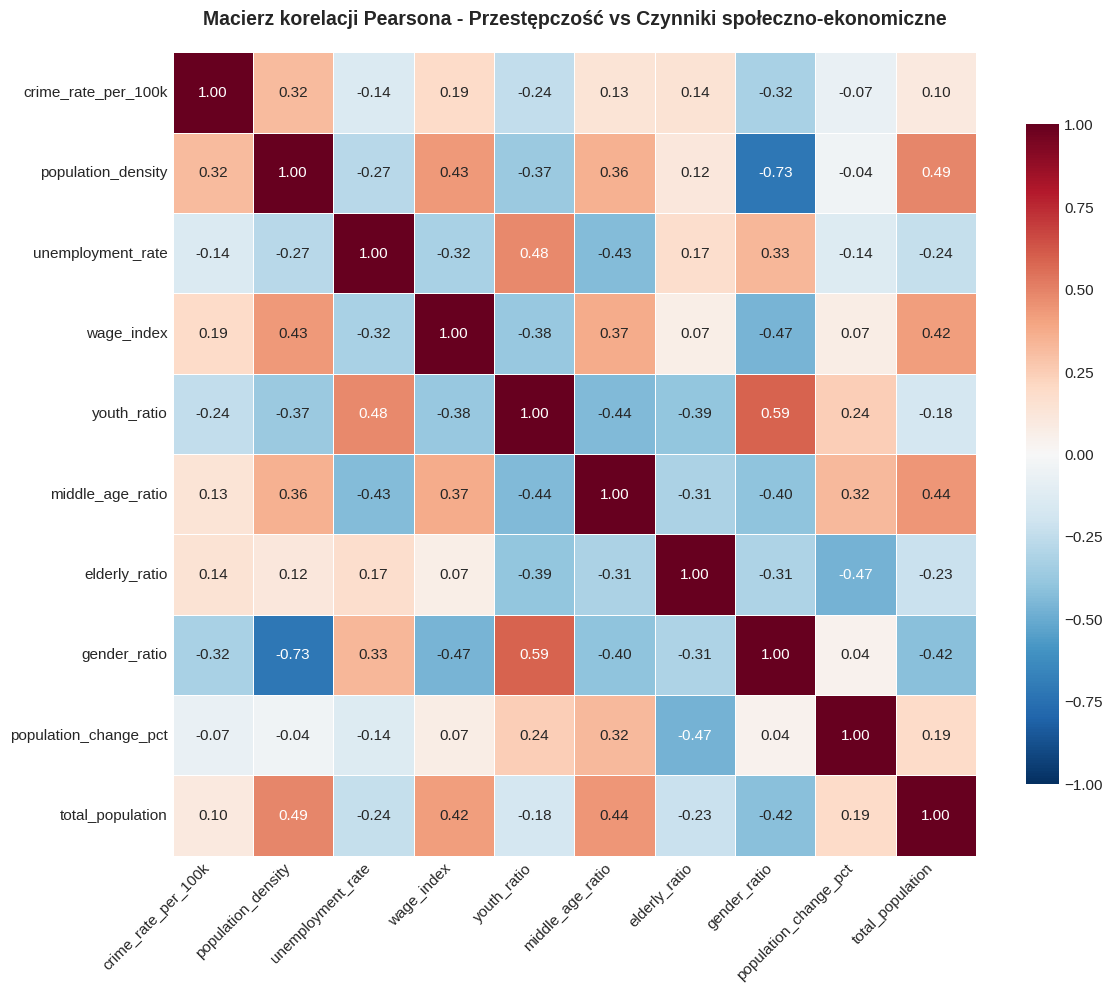


✓ Heatmapa zapisana jako 'korelacje_heatmapa.png'


In [73]:
fig, ax = plt.subplots(figsize=(12, 10))

# Tworzenie heatmapy
sns.heatmap(correlation_matrix, 
            annot=True,           # Pokazuj wartości
            fmt='.2f',            # Format liczb
            cmap='RdBu_r',        # Kolory: czerwony (dodatnia) - biały - niebieski (ujemna)
            center=0,             # Środek skali na 0
            square=True,          # Kwadratowe komórki
            linewidths=0.5,       # Linie między komórkami
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1,      # Zakres od -1 do 1
            ax=ax)

ax.set_title('Macierz korelacji Pearsona - Przestępczość vs Czynniki społeczno-ekonomiczne', 
             fontsize=14, fontweight='bold', pad=20)

# Rotacja etykiet
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('./output/imgs/korelacje_heatmapa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmapa zapisana jako 'korelacje_heatmapa.png'")


SCATTER PLOTS - WIZUALIZACJA ZALEŻNOŚCI


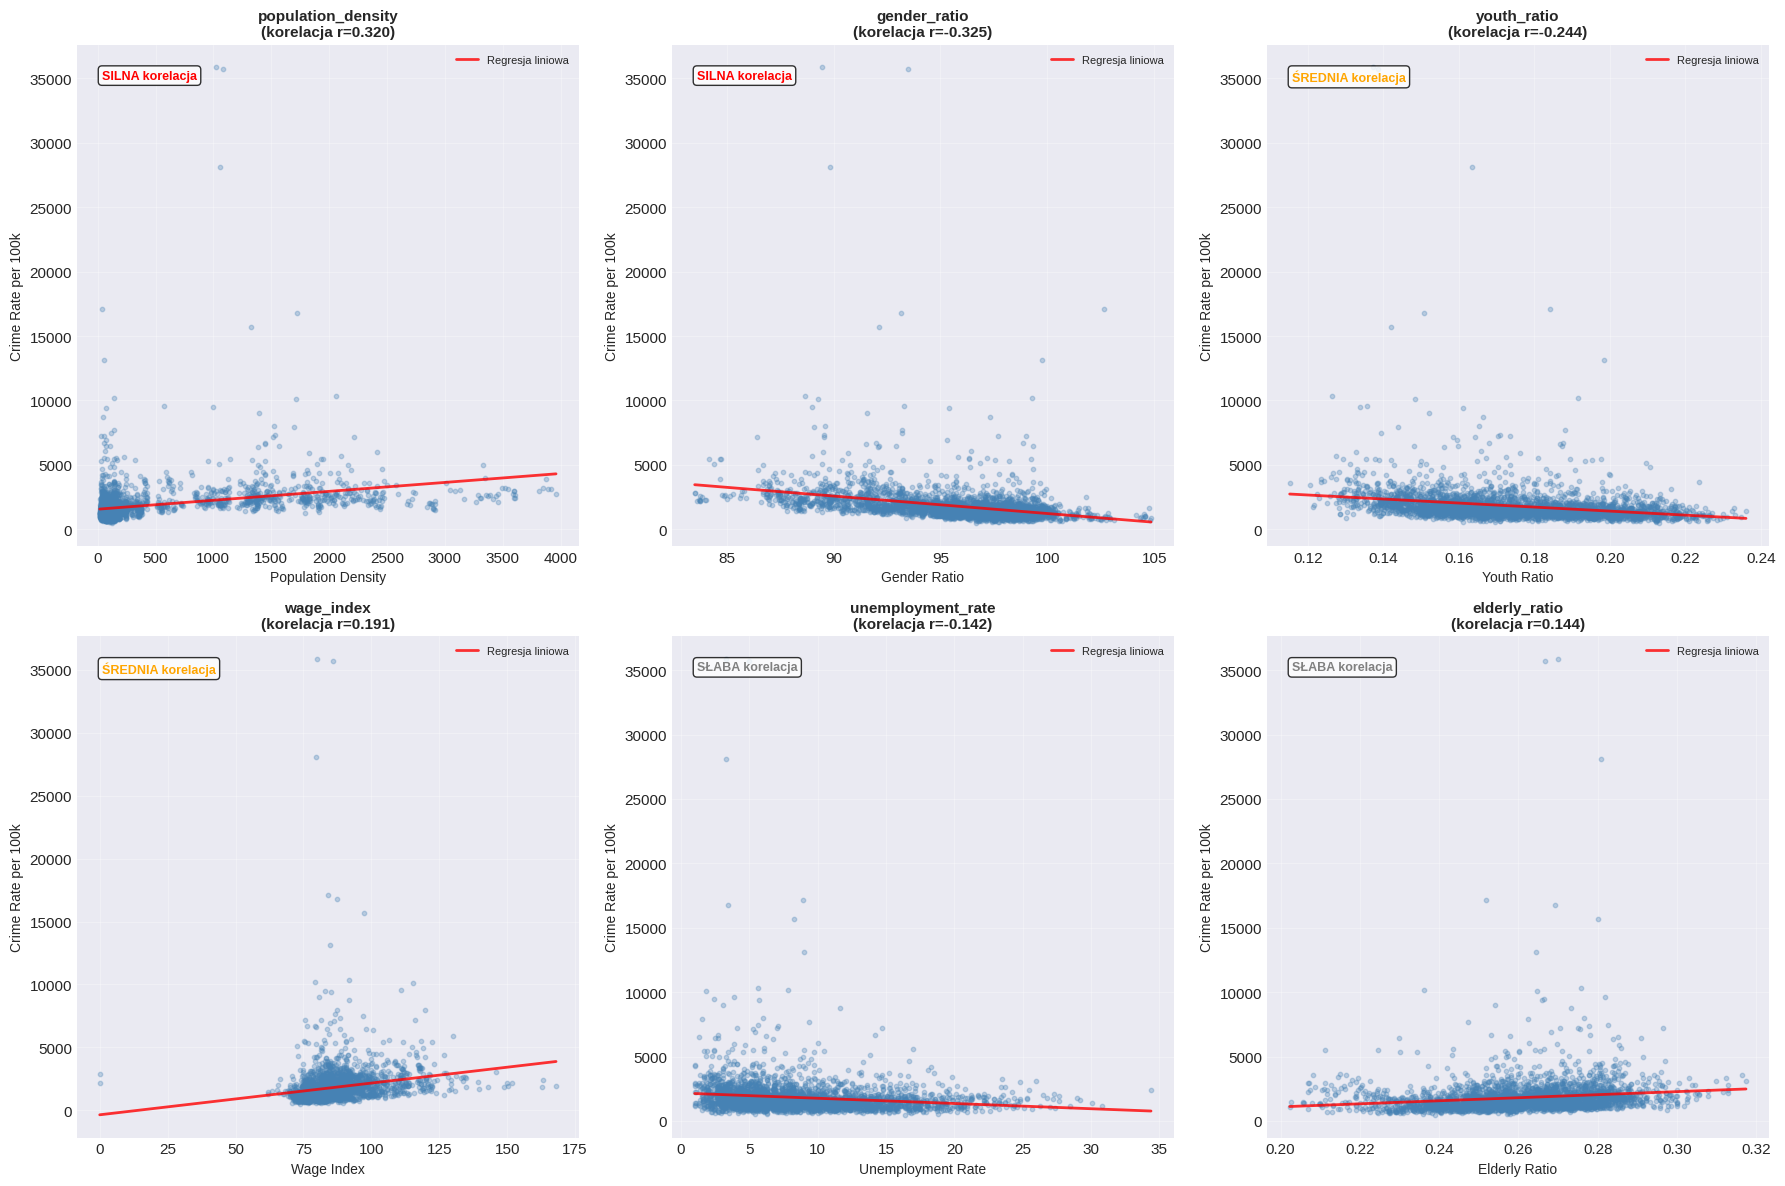


✓ Scatter plots zapisane jako 'korelacje_scatter_plots.png'


In [74]:
print("\n" + "="*80)
print("SCATTER PLOTS - WIZUALIZACJA ZALEŻNOŚCI")
print("="*80)

# Wybieramy 6 najważniejszych features do wizualizacji
top_features = [
    'population_density',
    'gender_ratio',
    'youth_ratio',
    'wage_index',
    'unemployment_rate',
    'elderly_ratio'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df_ml_ready[feature], df_ml_ready[target], alpha=0.3, s=10, color='steelblue')
    
    # Linia regresji
    z = np.polyfit(df_ml_ready[feature].dropna(), df_ml_ready[df_ml_ready[feature].notna()][target], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_ml_ready[feature].min(), df_ml_ready[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, alpha=0.8, label='Regresja liniowa')
    
    # Korelacja
    corr = correlation_matrix.loc[target, feature]
    
    # Tytuł i etykiety
    ax.set_title(f'{feature}\n(korelacja r={corr:.3f})', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Crime Rate per 100k', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Dodanie tekstu z interpretacją
    if abs(corr) > 0.3:
        strength = "SILNA"
        color = 'red'
    elif abs(corr) > 0.15:
        strength = "ŚREDNIA"
        color = 'orange'
    else:
        strength = "SŁABA"
        color = 'gray'
    
    ax.text(0.05, 0.95, f'{strength} korelacja', 
           transform=ax.transAxes, fontsize=9, 
           verticalalignment='top', color=color, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('./output/imgs/korelacje_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Scatter plots zapisane jako 'korelacje_scatter_plots.png'")

In [75]:
print("\n" + "="*80)
print("ANALIZA PARADOKSÓW I NIEINTUICYJNYCH ZALEŻNOŚCI")
print("="*80)

# Paradoks 1: Ujemna korelacja bezrobocia
print("\n🔍 PARADOKS 1: Bezrobocie vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'unemployment_rate']:.3f}")
print("   ⚠️  Intuicja: wyższe bezrobocie → więcej przestępstw")
print("   📊 Rzeczywistość: UJEMNA korelacja!")
print("\n   Możliwe wyjaśnienia:")
print("   - Miasta: niskie bezrobocie + wysoka przestępczość (więcej okazji)")
print("   - Wieś: wysokie bezrobocie + niska przestępczość (mniejsza gęstość)")
print("   - Confounding przez urbanizację")

# Sprawdzamy to przez podział na kategorie urbanizacji
if 'urbanization_category' in df_ml_ready.columns:
    urban_analysis = df_ml_ready.groupby('urbanization_category').agg({
        'crime_rate_per_100k': 'mean',
        'unemployment_rate': 'mean',
        'population_density': 'mean'
    }).round(1)
    print("\n   Średnie wartości według kategorii urbanizacji:")
    print(urban_analysis)

# Paradoks 2: Gender ratio
print("\n🔍 PARADOKS 2: Gender Ratio vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'gender_ratio']:.3f}")
print("   📊 Ujemna korelacja: więcej kobiet = więcej przestępstw?")
print("\n   Możliwe wyjaśnienia:")
print("   - Miasta mają więcej kobiet (migracja mężczyzn w poszukiwaniu pracy)")
print("   - Przestępczość wyższa w miastach z innych powodów")
print("   - To też efekt urbanizacji, nie gender per se")

# Paradoks 3: Youth ratio
print("\n🔍 PARADOKS 3: Udział Młodzieży vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'youth_ratio']:.3f}")
print("   ⚠️  Intuicja: więcej młodzieży → więcej przestępstw")
print("   📊 Rzeczywistość: UJEMNA korelacja!")
print("\n   Możliwe wyjaśnienia:")
print("   - Młodzież migruje do miast (więc wieś ma więcej młodzieży proporcjonalnie?)")
print("   - Miasta mają starzejącą się populację ale więcej przestępstw")
print("   - Potrzebna głębsza analiza")


ANALIZA PARADOKSÓW I NIEINTUICYJNYCH ZALEŻNOŚCI

🔍 PARADOKS 1: Bezrobocie vs Przestępczość
   Korelacja: -0.142
   ⚠️  Intuicja: wyższe bezrobocie → więcej przestępstw
   📊 Rzeczywistość: UJEMNA korelacja!

   Możliwe wyjaśnienia:
   - Miasta: niskie bezrobocie + wysoka przestępczość (więcej okazji)
   - Wieś: wysokie bezrobocie + niska przestępczość (mniejsza gęstość)
   - Confounding przez urbanizację

   Średnie wartości według kategorii urbanizacji:
                       crime_rate_per_100k  unemployment_rate  \
urbanization_category                                           
metro                               3016.3                5.8   
rural                               1510.6               10.4   
suburban                            1635.8                7.8   
urban                               2247.8                5.5   

                       population_density  
urbanization_category                      
metro                              1826.5  
rural             

In [76]:
print("\n" + "="*80)
print("TESTY STATYSTYCZNE - ISTOTNOŚĆ KORELACJI")
print("="*80)

print("\n--- Test istotności korelacji (p-value < 0.05 = istotna) ---")

for feature in top_features:
    # Test korelacji Pearsona
    corr_coef, p_value = stats.pearsonr(df_ml_ready[feature].dropna(), 
                                         df_ml_ready[df_ml_ready[feature].notna()][target])
    
    significance = "✓ ISTOTNA" if p_value < 0.05 else "✗ nieistotna"
    stars = ""
    if p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    
    print(f"\n{feature}:")
    print(f"   r = {corr_coef:+.3f}  |  p-value = {p_value:.6f}  {stars}  |  {significance}")

print("\n* p < 0.05,  ** p < 0.01,  *** p < 0.001")


TESTY STATYSTYCZNE - ISTOTNOŚĆ KORELACJI

--- Test istotności korelacji (p-value < 0.05 = istotna) ---

population_density:
   r = +0.320  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

gender_ratio:
   r = -0.325  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

youth_ratio:
   r = -0.244  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

wage_index:
   r = +0.191  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

unemployment_rate:
   r = -0.142  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

elderly_ratio:
   r = +0.144  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

* p < 0.05,  ** p < 0.01,  *** p < 0.001



ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII

--- Statystyki: urbanization_category ---
                         mean  median  count
urbanization_category                       
metro                  3016.3  2479.5    471
rural                  1510.6  1375.5   1620
suburban               1635.8  1489.2    879
urban                  2247.8  2003.6    209

--- Statystyki: unemployment_category ---
                         mean  median  count
unemployment_category                       
high                   1534.9  1414.1    385
low                    1798.6  1553.5   1363
medium                 1579.8  1428.6    612
very_low               2156.6  1783.8    819

--- Statystyki: wage_category ---
                 mean  median  count
wage_category                       
high           2463.9  2144.2    280
low            1499.4  1328.6    825
medium_high    2126.2  1942.6    456
medium_low     1778.5  1525.1   1616

--- Statystyki: population_size_category ---
                            me

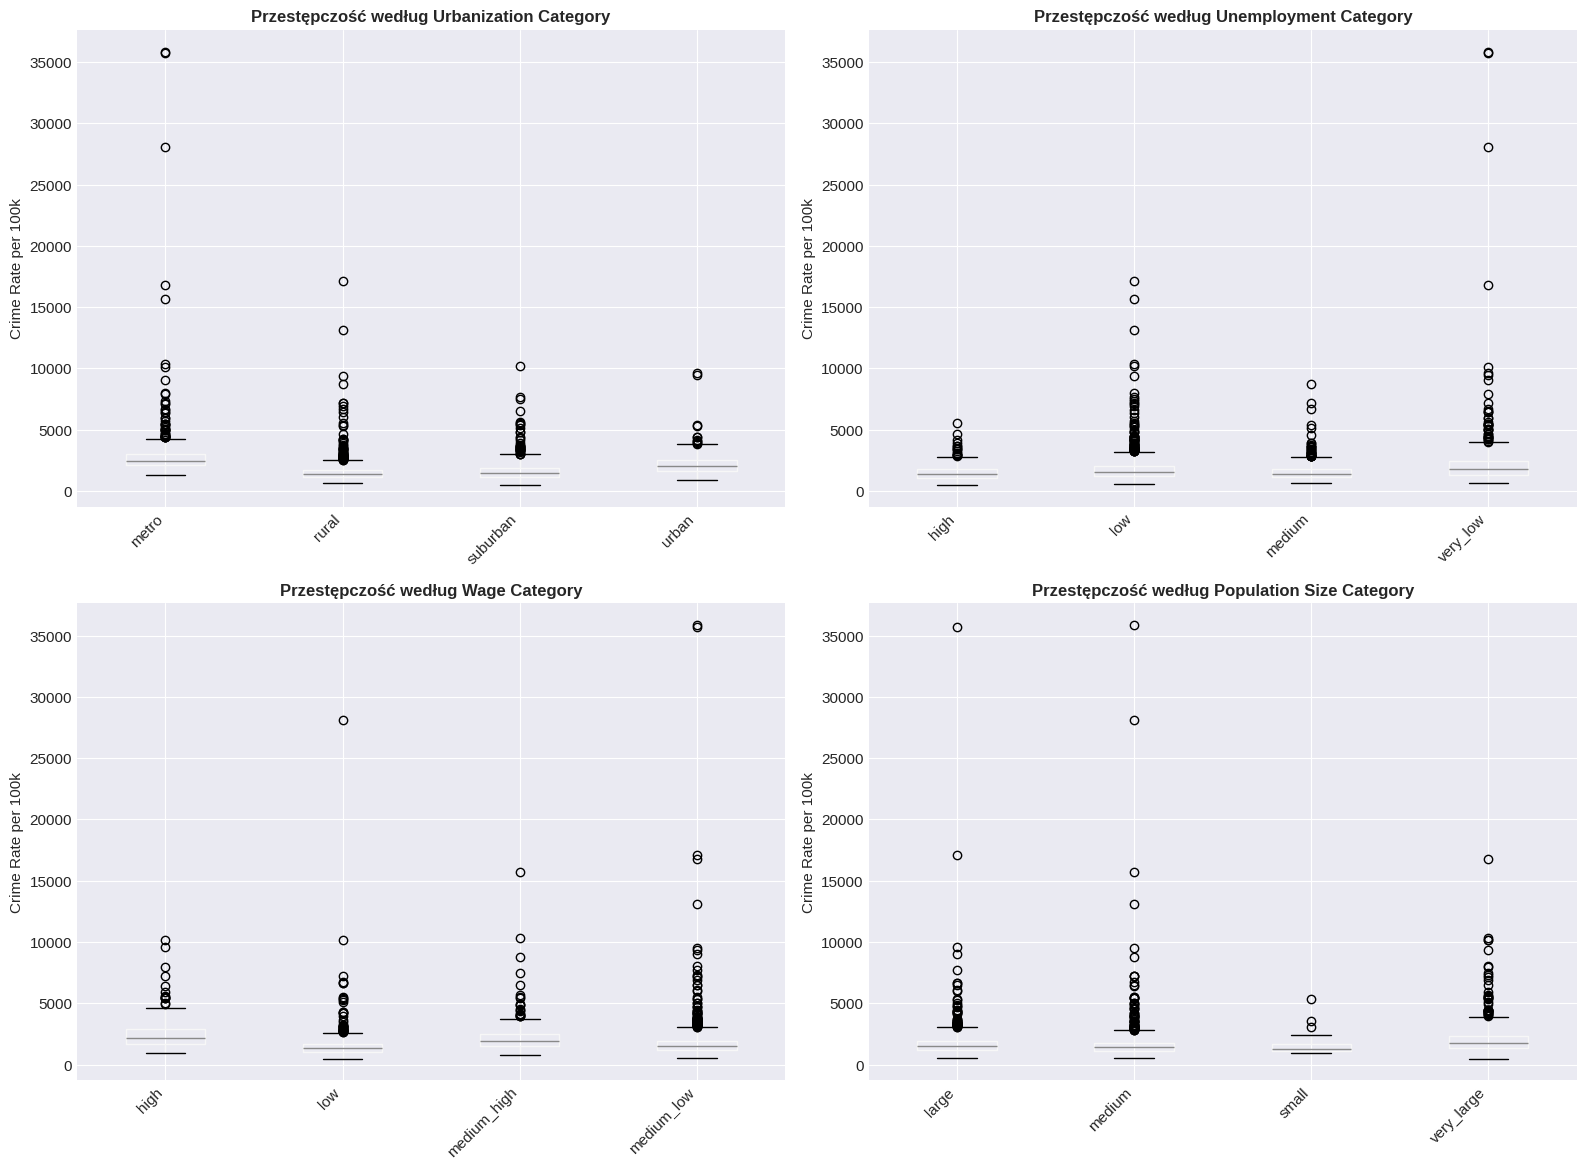


✓ Box plots zapisane jako 'korelacje_kategorie_boxplots.png'


In [77]:
print("\n" + "="*80)
print("ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII")
print("="*80)

# Jeśli mamy kategorie w datasecie
categorical_vars = ['urbanization_category', 'unemployment_category', 
                    'wage_category', 'population_size_category']

existing_cats = [cat for cat in categorical_vars if cat in df_ml_ready.columns]

if existing_cats:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, cat_var in enumerate(existing_cats[:4]):
        ax = axes[idx]
        
        # Box plot
        df_sorted = df_ml_ready.sort_values(cat_var)
        df_sorted.boxplot(column='crime_rate_per_100k', by=cat_var, ax=ax)
        
        ax.set_title(f'Przestępczość według {cat_var.replace("_", " ").title()}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Crime Rate per 100k', fontsize=11)
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
        
        # Statystyki
        stats_by_cat = df_ml_ready.groupby(cat_var)['crime_rate_per_100k'].agg(['mean', 'median', 'count'])
        print(f"\n--- Statystyki: {cat_var} ---")
        print(stats_by_cat.round(1))
    
    plt.suptitle('')  # Usuń domyślny tytuł
    plt.tight_layout()
    plt.savefig('./output/imgs/korelacje_kategorie_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Box plots zapisane jako 'korelacje_kategorie_boxplots.png'")

In [78]:
print("\n" + "="*80)
print("RANKING NAJSILNIEJSZYCH PREDYKTORÓW PRZESTĘPCZOŚCI")
print("="*80)

# Ranking według absolutnej wartości korelacji
predictor_ranking = abs_correlations[1:].sort_values(ascending=False)

print("\n🏆 TOP predyktory (według |r|):\n")
for rank, (feature, corr_abs) in enumerate(predictor_ranking.items(), 1):
    corr_actual = correlations_with_target[feature]
    direction = "↑ dodatnia" if corr_actual > 0 else "↓ ujemna"
    
    # Ocena siły
    if corr_abs > 0.4:
        strength = "BARDZO SILNA"
    elif corr_abs > 0.3:
        strength = "SILNA"
    elif corr_abs > 0.2:
        strength = "ŚREDNIA"
    elif corr_abs > 0.1:
        strength = "SŁABA"
    else:
        strength = "BARDZO SŁABA"
    
    print(f"{rank}. {feature:30s} | r={corr_actual:+.3f} | {direction:15s} | {strength}")

# =============================================================================
# 10. PODSUMOWANIE KLUCZOWYCH WNIOSKÓW
# =============================================================================

print("\n" + "="*80)
print("KLUCZOWE WNIOSKI Z ANALIZY KORELACJI")
print("="*80)

print("\n📌 NAJWAŻNIEJSZE ODKRYCIA:\n")

# Top 3 korelacje
top3 = predictor_ranking.head(3)
print("1. NAJSILNIEJSZE KORELACJE:")
for feature in top3.index:
    corr = correlations_with_target[feature]
    print(f"   • {feature}: r={corr:+.3f}")

print("\n2. PARADOKSY I NIEINTUICYJNE ZALEŻNOŚCI:")
print("   • Bezrobocie: ujemna korelacja (prawdopodobnie efekt urbanizacji)")
print("   • Gender ratio: ujemna korelacja (więcej kobiet w miastach)")
print("   • Youth ratio: ujemna korelacja (młodzież migruje?)")

print("\n3. URBANIZACJA JAKO KLUCZOWY CZYNNIK:")
print("   • Gęstość zaludnienia ma najsilniejszą korelację")
print("   • Miasta: wysokie zarobki + niska stopa bezrobocia + wysoka przestępczość")
print("   • Wieś: niskie zarobki + wysokie bezrobocie + niska przestępczość")

print("\n4. UWAGA - KORELACJA ≠ PRZYCZYNOWOŚĆ:")
print("   • Wszystkie zależności są KORELACYJNE, nie KAUZALNE")
print("   • Występują efekty confounding (np. urbanizacja)")
print("   • Potrzebne modele wieloczynnikowe do wyjaśnienia zależności")

print("\n" + "="*80)
print("CZĘŚĆ 2 ZAKOŃCZONA - Analiza korelacji")
print("="*80)


RANKING NAJSILNIEJSZYCH PREDYKTORÓW PRZESTĘPCZOŚCI

🏆 TOP predyktory (według |r|):

1. gender_ratio                   | r=-0.325 | ↓ ujemna        | SILNA
2. population_density             | r=+0.320 | ↑ dodatnia      | SILNA
3. youth_ratio                    | r=-0.244 | ↓ ujemna        | ŚREDNIA
4. wage_index                     | r=+0.191 | ↑ dodatnia      | SŁABA
5. elderly_ratio                  | r=+0.144 | ↑ dodatnia      | SŁABA
6. unemployment_rate              | r=-0.142 | ↓ ujemna        | SŁABA
7. middle_age_ratio               | r=+0.133 | ↑ dodatnia      | SŁABA
8. total_population               | r=+0.098 | ↑ dodatnia      | BARDZO SŁABA
9. population_change_pct          | r=-0.071 | ↓ ujemna        | BARDZO SŁABA

KLUCZOWE WNIOSKI Z ANALIZY KORELACJI

📌 NAJWAŻNIEJSZE ODKRYCIA:

1. NAJSILNIEJSZE KORELACJE:
   • gender_ratio: r=-0.325
   • population_density: r=+0.320
   • youth_ratio: r=-0.244

2. PARADOKSY I NIEINTUICYJNE ZALEŻNOŚCI:
   • Bezrobocie: ujemna korelacja (

In [79]:
print("="*80)
print("REGRESJA WIELOKROTNA - ANALIZA WPŁYWU WIELU CZYNNIKÓW JEDNOCZEŚNIE")
print("="*80)

features = [
    "population_density",
    "unemployment_rate",
    "wage_index",
    "youth_ratio",
    "gender_ratio"
]

X = df_ml_ready[features]
y = df_ml_ready["crime_rate_per_100k"]

# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled).fit()

REGRESJA WIELOKROTNA - ANALIZA WPŁYWU WIELU CZYNNIKÓW JEDNOCZEŚNIE


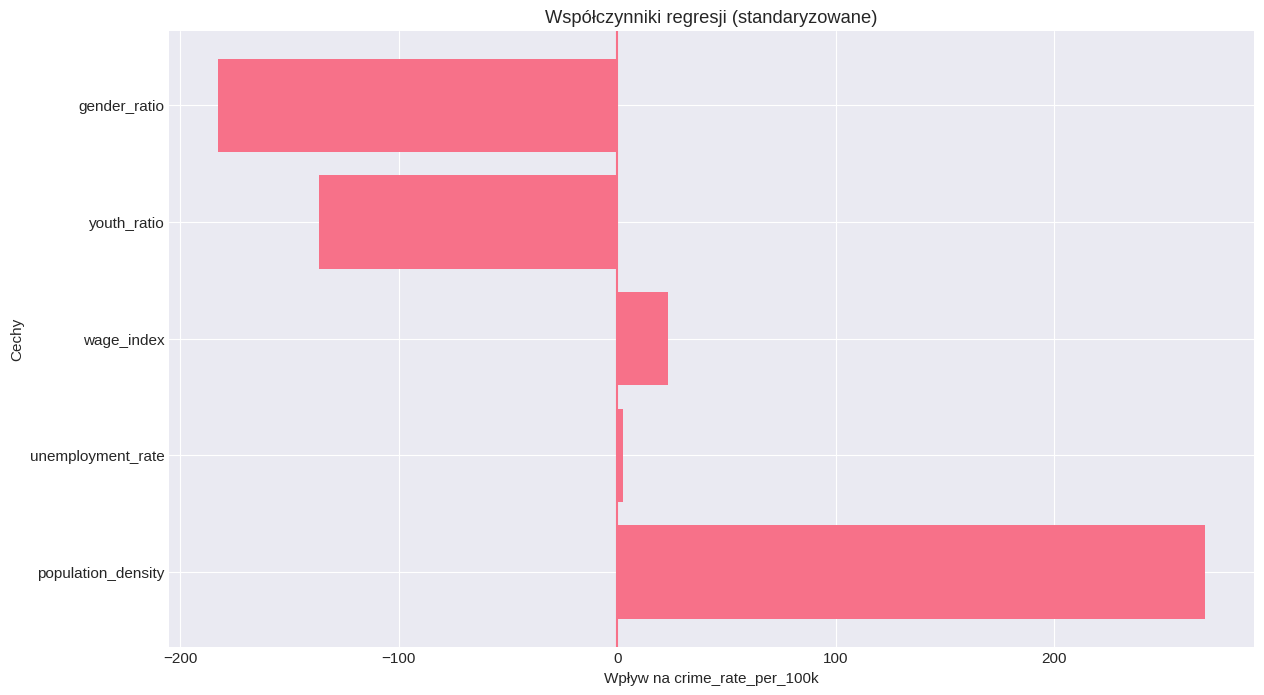

In [80]:
coef_df = pd.DataFrame({
    "feature": ["const"] + features,
    "coefficient": model.params
})

coef_df = coef_df[coef_df["feature"] != "const"]

plt.figure()
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.axvline(0)
plt.title("Współczynniki regresji (standaryzowane)")
plt.xlabel("Wpływ na crime_rate_per_100k")
plt.ylabel("Cechy")
plt.show()

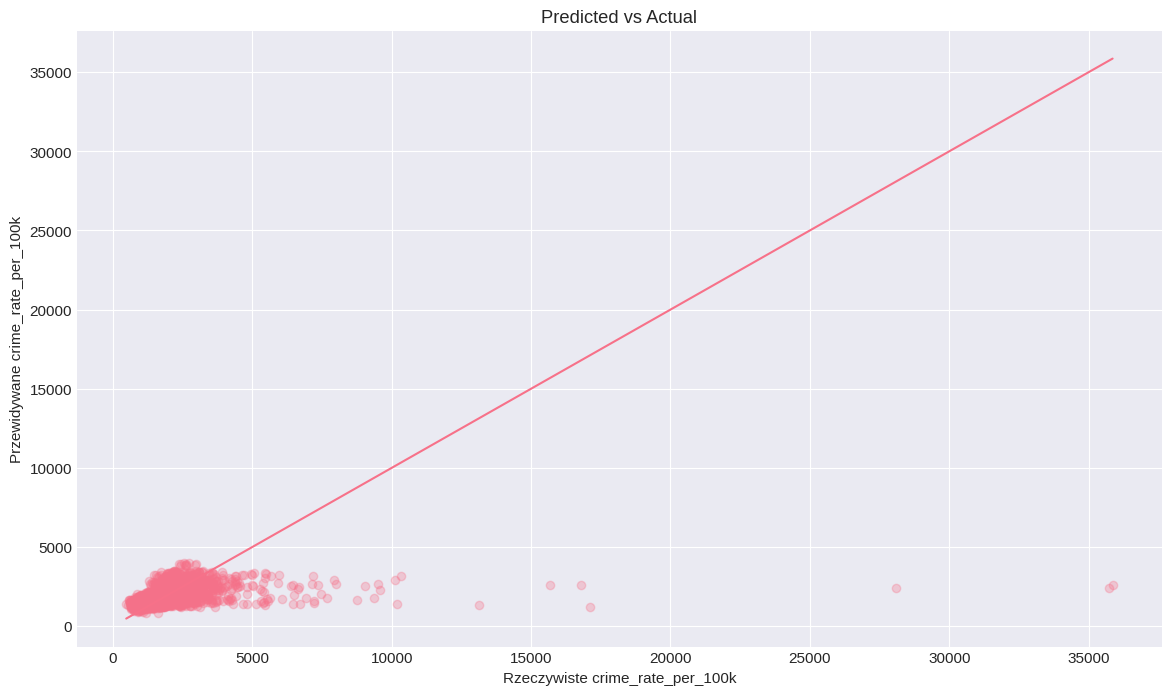

In [81]:
y_pred = model.predict(X_scaled)

plt.figure()
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Rzeczywiste crime_rate_per_100k")
plt.ylabel("Przewidywane crime_rate_per_100k")
plt.title("Predicted vs Actual")
plt.show()

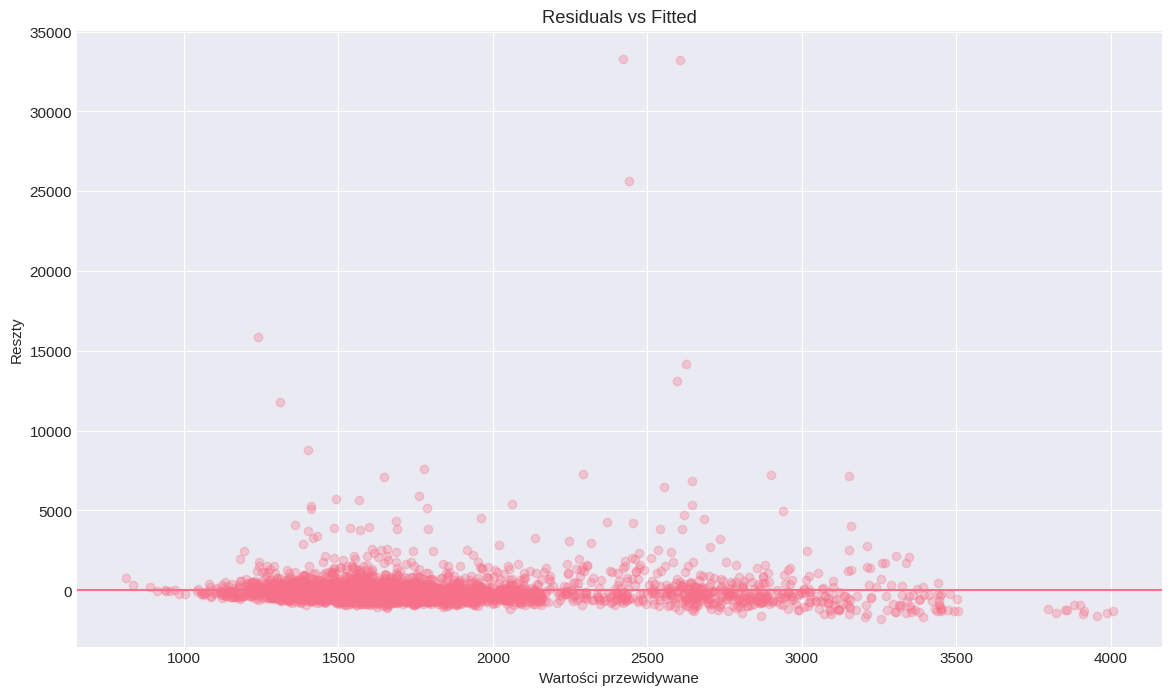

In [82]:
residuals = y - y_pred

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Wartości przewidywane")
plt.ylabel("Reszty")
plt.title("Residuals vs Fitted")
plt.show()


DIAGNOSTYKA MODELU - ANALIZA RESIDUALS

--- Statystyki residuals ---
Średnia: 0.000000 (powinno być ~0)
Odch. std: 1347.83
Skewness: 13.858 (symetryczny rozkład ~0)
Kurtosis: 290.735 (normalny rozkład ~0)

Test Jarque-Bera (normalność residuals):
  Statystyka: 11298018.61
  p-value: 0.0000
  ✗ Residuals NIE mają rozkładu normalnego (p<0.05)

Test Durbin-Watson (autokorelacja residuals):
  Statystyka: 1.679
  Interpretacja: 2.0 = brak autokorelacji
  ✓ Brak problematycznej autokorelacji


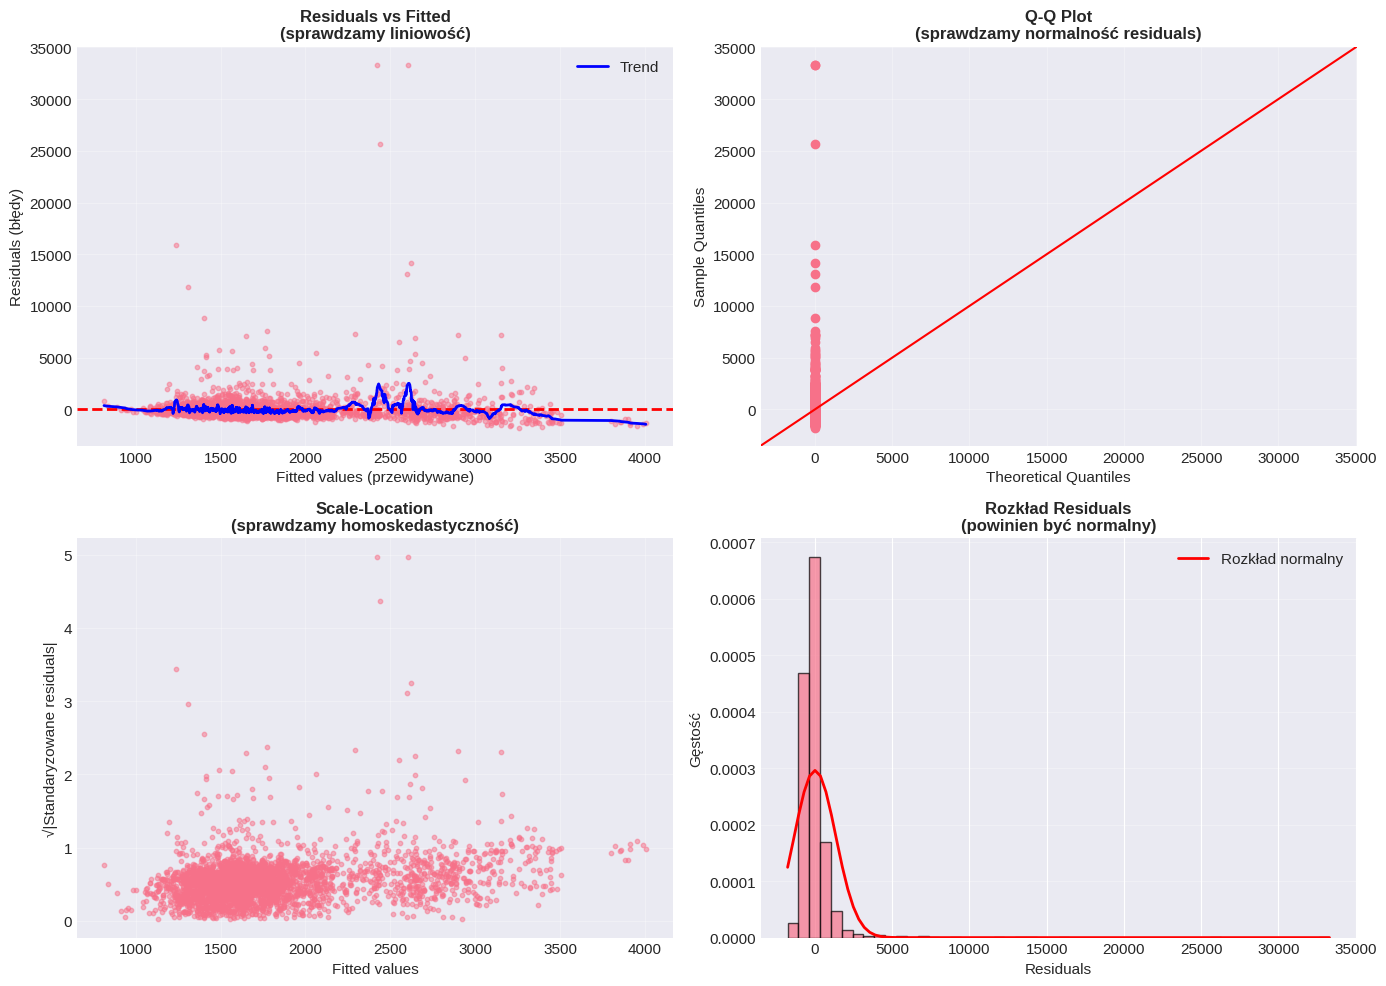


✓ Diagnostyka zapisana jako 'regression_diagnostics.png'


In [83]:
print("\n" + "="*80)
print("DIAGNOSTYKA MODELU - ANALIZA RESIDUALS")
print("="*80)

# Obliczenie residuals
residuals = model.resid
fitted_values = model.fittedvalues

# Statystyki residuals
print("\n--- Statystyki residuals ---")
print(f"Średnia: {residuals.mean():.6f} (powinno być ~0)")
print(f"Odch. std: {residuals.std():.2f}")
print(f"Skewness: {stats.skew(residuals):.3f} (symetryczny rozkład ~0)")
print(f"Kurtosis: {stats.kurtosis(residuals):.3f} (normalny rozkład ~0)")

# Test normalności residuals - Jarque-Bera
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nTest Jarque-Bera (normalność residuals):")
print(f"  Statystyka: {jb_stat:.2f}")
print(f"  p-value: {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print("  ✓ Residuals mają rozkład normalny (p>0.05)")
else:
    print("  ✗ Residuals NIE mają rozkładu normalnego (p<0.05)")

# Test Durbin-Watson (autokorelacja)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nTest Durbin-Watson (autokorelacja residuals):")
print(f"  Statystyka: {dw_stat:.3f}")
print(f"  Interpretacja: 2.0 = brak autokorelacji")
if 1.5 < dw_stat < 2.5:
    print("  ✓ Brak problematycznej autokorelacji")
else:
    print("  ⚠️ Możliwa autokorelacja residuals")

# Wizualizacja diagnostyki
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
ax1 = axes[0, 0]
ax1.scatter(fitted_values, residuals, alpha=0.5, s=10)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Fitted values (przewidywane)', fontsize=11)
ax1.set_ylabel('Residuals (błędy)', fontsize=11)
ax1.set_title('Residuals vs Fitted\n(sprawdzamy liniowość)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Dodanie smooth line
from scipy.signal import savgol_filter
sorted_idx = np.argsort(fitted_values)
try:
    smooth = savgol_filter(residuals.iloc[sorted_idx], 51, 3)
    ax1.plot(fitted_values.iloc[sorted_idx], smooth, color='blue', linewidth=2, label='Trend')
    ax1.legend()
except:
    pass

# 2. Q-Q Plot (normalność residuals)
ax2 = axes[0, 1]
qq = ProbPlot(residuals)
qq.qqplot(line='45', ax=ax2)
ax2.set_title('Q-Q Plot\n(sprawdzamy normalność residuals)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Scale-Location (homoskedastyczność)
ax3 = axes[1, 0]
standardized_residuals = residuals / residuals.std()
ax3.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=10)
ax3.set_xlabel('Fitted values', fontsize=11)
ax3.set_ylabel('√|Standaryzowane residuals|', fontsize=11)
ax3.set_title('Scale-Location\n(sprawdzamy homoskedastyczność)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Histogram residuals
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
# Dodanie krzywej normalnej
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax4.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Rozkład normalny')
ax4.set_xlabel('Residuals', fontsize=11)
ax4.set_ylabel('Gęstość', fontsize=11)
ax4.set_title('Rozkład Residuals\n(powinien być normalny)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./output/imgs/regression_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Diagnostyka zapisana jako 'regression_diagnostics.png'")

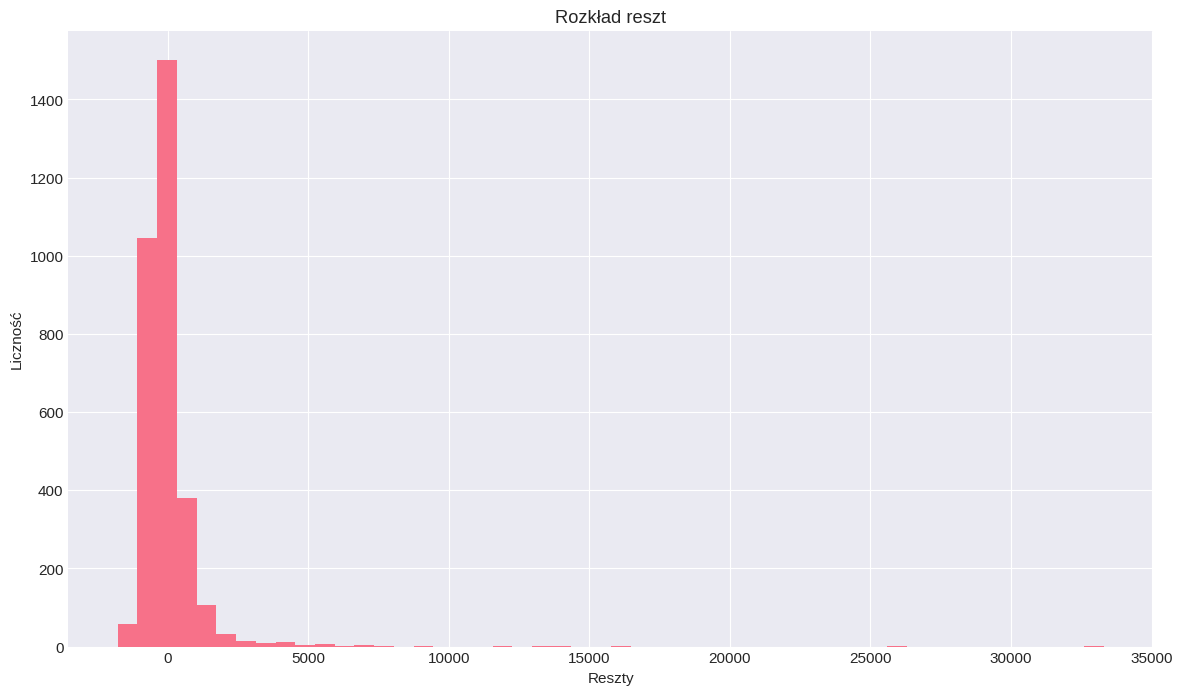

In [84]:
plt.figure()
plt.hist(residuals, bins=50)
plt.title("Rozkład reszt")
plt.xlabel("Reszty")
plt.ylabel("Liczność")
plt.show()

RANDOM FOREST

=== WYNIKI RANDOM FOREST ===
R² (train): 0.316
R² (test):  0.176
RMSE (test): 1153
MAE (test):  541

Cross-validation R² (mean): 0.084 ± 0.071

=== WAŻNOŚĆ CECH ===
              feature  importance
0  population_density    0.363658
4        gender_ratio    0.262221
3         youth_ratio    0.141215
2          wage_index    0.132907
1   unemployment_rate    0.099999


/tmp/ipykernel_26538/625749152.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


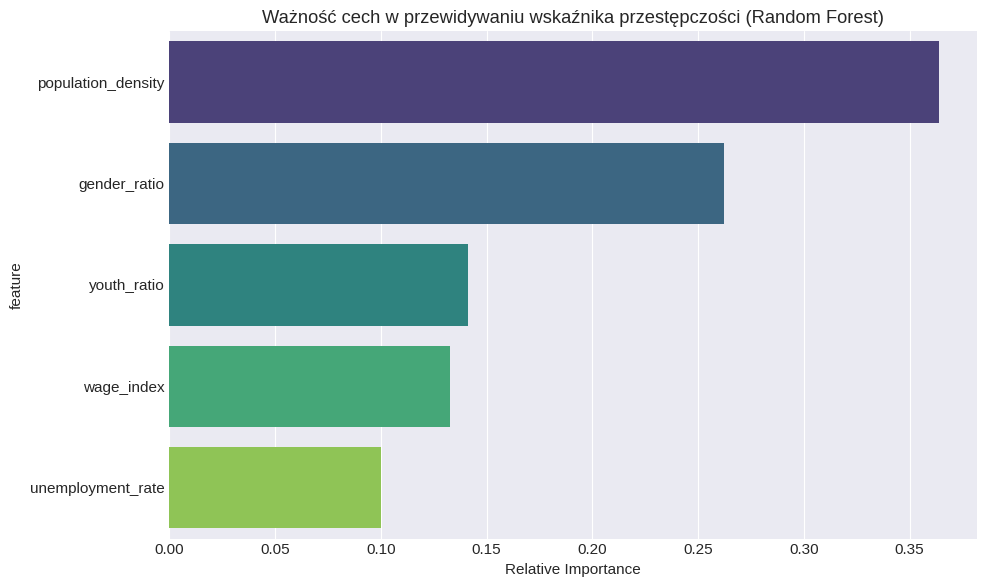

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,          # Ograniczenie głębokości - zapobiega przeuczeniu
    min_samples_split=20,  # Wymaga min 20 próbek do podziału
    min_samples_leaf=10,   # Min 10 próbek w liściu
    max_features='sqrt',   # Użyj sqrt(n_features) na każdy split
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predykcja
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Metryki
print("=== WYNIKI RANDOM FOREST ===")
print(f"R² (train): {r2_score(y_train, y_pred_train):.3f}")
print(f"R² (test):  {r2_score(y_test, y_pred_test):.3f}")
print(f"RMSE (test): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.0f}")
print(f"MAE (test):  {mean_absolute_error(y_test, y_pred_test):.0f}")

# Cross-validation (5-fold)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validation R² (mean): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== WAŻNOŚĆ CECH ===")
print(feature_importance)

# Wizualizacja Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Ważność cech w przewidywaniu wskaźnika przestępczości (Random Forest)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('./output/imgs/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

Karta Polski według pozioma przestępczośći

MAPA POLSKI - PRZESTĘPCZOŚĆ WEDŁUG WOJEWÓDZTW (2024)
✓ Połączono dane geograficzne z danymi o przestępczości
  Województwa z danymi: 16/16


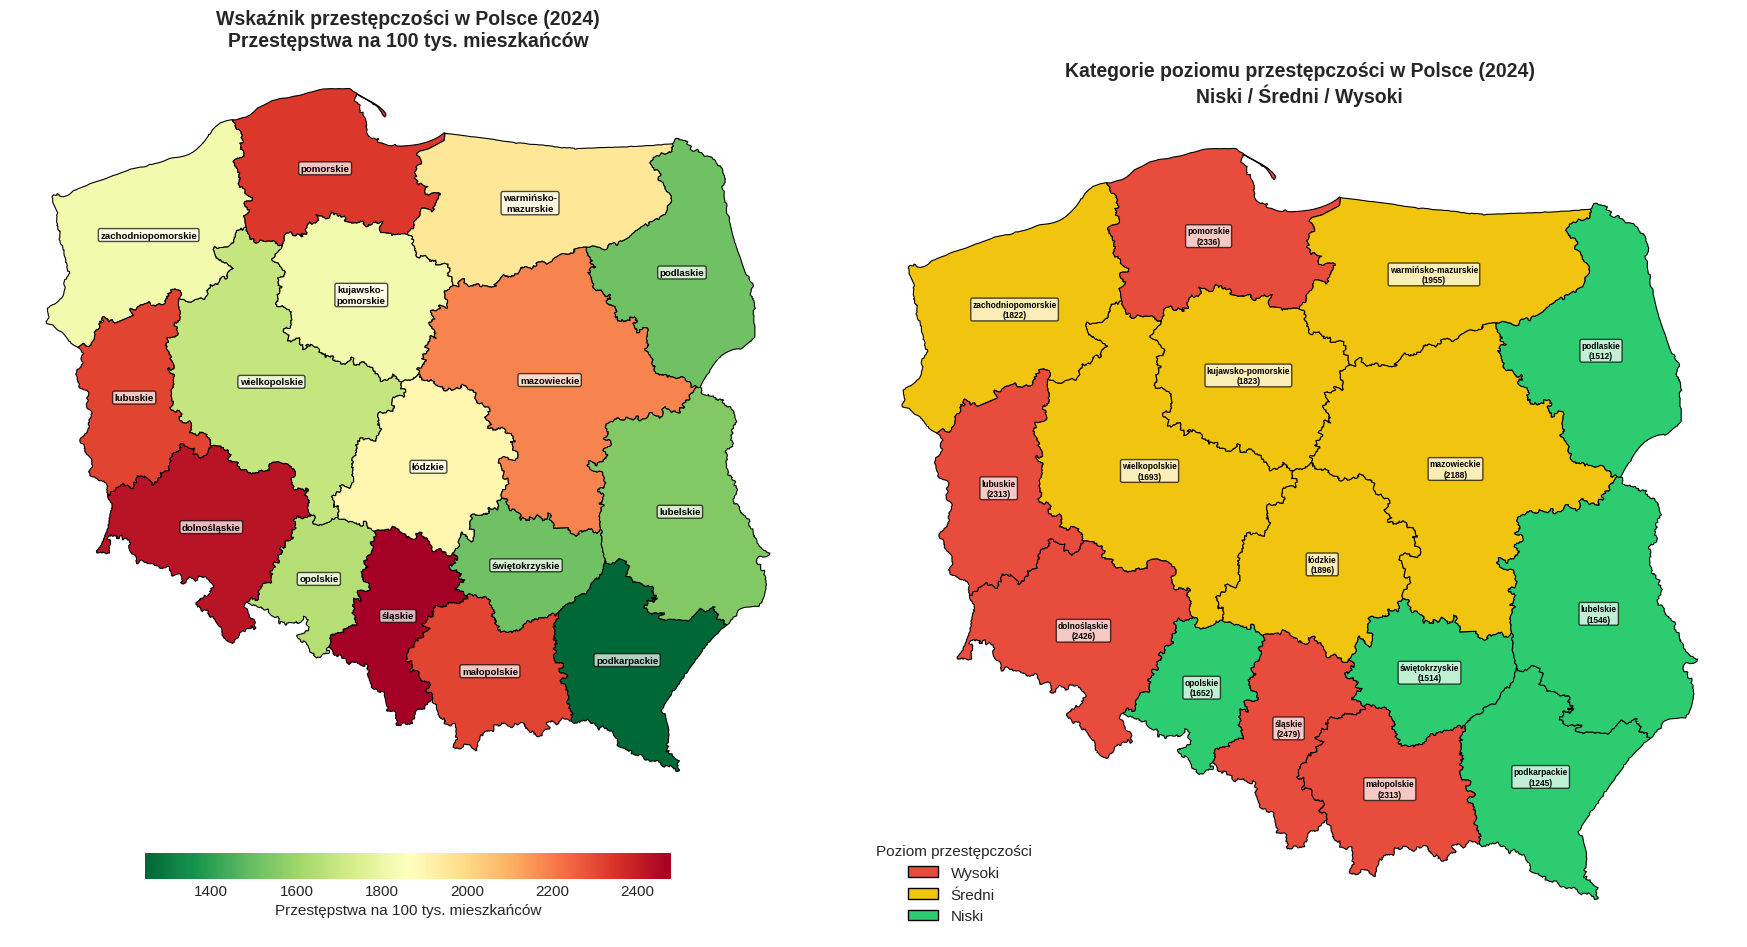


✓ Mapa zapisana jako 'mapa_przestepczosc_wojewodztwa.png'

PODSUMOWANIE - KATEGORIE PRZESTĘPCZOŚCI

Progi kategorii:
  Niski:  ≤ 1691 przestępstw na 100k
  Średni: 1691 - 2194 przestępstw na 100k
  Wysoki: > 2194 przestępstw na 100k

--- Województwa według kategorii ---

Wysoki poziom (5 woj.):
  • śląskie: 2479
  • dolnośląskie: 2426
  • małopolskie: 2313
  • pomorskie: 2336
  • lubuskie: 2313

Średni poziom (6 woj.):
  • wielkopolskie: 1693
  • zachodniopomorskie: 1822
  • kujawsko-pomorskie: 1823
  • warmińsko-mazurskie: 1955
  • łódzkie: 1896
  • mazowieckie: 2188

Niski poziom (5 woj.):
  • opolskie: 1652
  • świętokrzyskie: 1514
  • podlaskie: 1512
  • podkarpackie: 1245
  • lubelskie: 1546


In [86]:
import geopandas as gpd

print("="*80)
print("MAPA POLSKI - PRZESTĘPCZOŚĆ WEDŁUG WOJEWÓDZTW (2024)")
print("="*80)

# Wczytanie danych geograficznych
gdf = gpd.read_file('./data/geo/wojewodztwa.geojson')

# Przygotowanie danych o przestępczości na poziomie województw (2024)
# Używamy już obliczonych danych z wcześniejszej analizy
wojewodztwa_2024_map = wojewodztwa_2024.copy()
wojewodztwa_2024_map['nazwa'] = wojewodztwa_2024_map['wojewodztwo']

# Połączenie danych geograficznych z danymi o przestępczości
gdf_merged = gdf.merge(wojewodztwa_2024_map, on='nazwa', how='left')

print(f"✓ Połączono dane geograficzne z danymi o przestępczości")
print(f"  Województwa z danymi: {gdf_merged['crime_rate_per_100k'].notna().sum()}/16")

# Tworzenie mapy
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Mapa 1: Choropleth - poziom przestępczości
ax1 = axes[0]
gdf_merged.plot(
    column='crime_rate_per_100k',
    cmap='RdYlGn_r',  # Czerwony = wysoka przestępczość, Zielony = niska
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': 'Przestępstwa na 100 tys. mieszkańców',
        'orientation': 'horizontal',
        'shrink': 0.6,
        'pad': 0.05
    },
    ax=ax1
)

# Dodanie nazw województw na mapie
for idx, row in gdf_merged.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(
        row['nazwa'].replace('-', '-\n'),
        xy=(centroid.x, centroid.y),
        ha='center', va='center',
        fontsize=7,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax1.set_title('Wskaźnik przestępczości w Polsce (2024)\nPrzestępstwa na 100 tys. mieszkańców', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Mapa 2: Kategorie przestępczości (niski/średni/wysoki)
ax2 = axes[1]

# Podział na kategorie
crime_median = gdf_merged['crime_rate_per_100k'].median()
crime_q1 = gdf_merged['crime_rate_per_100k'].quantile(0.33)
crime_q3 = gdf_merged['crime_rate_per_100k'].quantile(0.67)

def categorize_crime(rate):
    if pd.isna(rate):
        return 'Brak danych'
    elif rate <= crime_q1:
        return 'Niski'
    elif rate <= crime_q3:
        return 'Średni'
    else:
        return 'Wysoki'

gdf_merged['crime_category'] = gdf_merged['crime_rate_per_100k'].apply(categorize_crime)

# Колоры для категорий - явный маппинг
category_colors = {'Niski': '#2ecc71', 'Średni': '#f1c40f', 'Wysoki': '#e74c3c', 'Brak danych': '#bdc3c7'}

# Применяем цвета к каждому региону
gdf_merged['color'] = gdf_merged['crime_category'].map(category_colors)

gdf_merged.plot(
    color=gdf_merged['color'],
    linewidth=0.8,
    edgecolor='black',
    ax=ax2
)

# Создаём легенду вручную
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Wysoki'),
    Patch(facecolor='#f1c40f', edgecolor='black', label='Średni'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='Niski')
]
ax2.legend(handles=legend_elements, loc='lower left', title='Poziom przestępczości')

# Dodanie nazw i wartości na mapie
for idx, row in gdf_merged.iterrows():
    centroid = row.geometry.centroid
    label = f"{row['nazwa']}\n({row['crime_rate_per_100k']:.0f})" if pd.notna(row['crime_rate_per_100k']) else row['nazwa']
    ax2.annotate(
        label,
        xy=(centroid.x, centroid.y),
        ha='center', va='center',
        fontsize=6,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax2.set_title('Kategorie poziomu przestępczości w Polsce (2024)\nNiski / Średni / Wysoki', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('./output/imgs/mapa_przestepczosc_wojewodztwa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Mapa zapisana jako 'mapa_przestepczosc_wojewodztwa.png'")

# Podsumowanie statystyk
print("\n" + "="*80)
print("PODSUMOWANIE - KATEGORIE PRZESTĘPCZOŚCI")
print("="*80)
print(f"\nProgi kategorii:")
print(f"  Niski:  ≤ {crime_q1:.0f} przestępstw na 100k")
print(f"  Średni: {crime_q1:.0f} - {crime_q3:.0f} przestępstw na 100k")
print(f"  Wysoki: > {crime_q3:.0f} przestępstw na 100k")

print("\n--- Województwa według kategorii ---")
for cat in ['Wysoki', 'Średni', 'Niski']:
    woj_list = gdf_merged[gdf_merged['crime_category'] == cat]['nazwa'].tolist()
    print(f"\n{cat} poziom ({len(woj_list)} woj.):")
    for woj in woj_list:
        rate = gdf_merged[gdf_merged['nazwa'] == woj]['crime_rate_per_100k'].values[0]
        print(f"  • {woj}: {rate:.0f}")